In [1]:
import numpy as np
import pandas as pd
import polars as pl
import yfinance as yf
from datetime import datetime

import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st

np.set_printoptions(precision=3)

pd.set_option("display.float_format", lambda x: "%.3f" % x)

plt.style.use("ggplot")

mpl.rcParams["figure.figsize"] = (30, 5)
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

import warnings

warnings.simplefilter("ignore")

## ❓ <a id = "top"> Parts </a> ❓

## [Part 1: Trading Strategies](#part1)
### &emsp;&emsp; [Part 1.1 Trend-Following Momentum](#part1.1)
### &emsp;&emsp;&emsp;&emsp; [Part 1.1.1 Moving Average Crossovers](#part1.1.1)
### &emsp;&emsp;&emsp;&emsp; [Part 1.1.2 Passive Following](#part1.1.2)
### &emsp;&emsp;&emsp;&emsp; [Part 1.1.3 RSI](#part1.1.3)

### &emsp;&emsp; [Part 1.2 Mean Reversion](#meanreversion)

### &emsp;&emsp; [Part 1.2 Machine Learning](#ML)

## [Part 2: Performance](#part2)

## [Part 3: Top 3 Strategies](#part3)
### &emsp;&emsp; [Part 3.1 Executive Summary](#summary)

## [Part 4: Critque](#part4)

## [Best](#Best)

# Config

In [2]:
# Portfolio
ticker = "SPY"
start_date = "2005-11-01"
end_date = "2024-11-01"
capital = 100_000

# SPY information
SPY = yf.download(tickers=ticker, start=start_date, end=end_date)
SPY_price = SPY[["Adj Close"]]
SPY_price.columns = [ticker]
SPY_returns = np.log(SPY_price).diff().fillna(0)
baseline_SPY = np.exp(SPY_returns.cumsum()).values.flatten()

# 80 / 20 split
prop = 0.8
ideation_len = int(len(SPY_price) * prop)
testing_len = int(len(SPY_price) * (1 - prop))

# Date index
ideation_index = SPY_price.iloc[: ideation_len + 1,].index
testing_index = SPY_price.iloc[-testing_len:,].index

ideation_returns = SPY_returns[SPY_returns.index.isin(ideation_index)].values.flatten()
testing_returns = SPY_returns[SPY_returns.index.isin(testing_index)].values.flatten()

# ML
numfolds = 10
random_state = 627

[*********************100%%**********************]  1 of 1 completed


In [3]:
class indicators:
    def __init__(self, df: pd.DataFrame, tickers: list) -> None:
        """
        Computes technical indicators

        Parameters
        ----------
        df : pd.DataFrame
            DataFrame of prices with date as index
        """
        self.df = pl.from_pandas(df)
        self.price = self.df[tickers]
        self.tickers = tickers

    def SMA(self, windows: list[int]) -> pd.DataFrame:
        """
        Compute simple moving average indicator

        Parameters
        ----------
        windows : list[int]
            Rolling windows

        Returns
        -------
        pd.DataFrame
            Moving Average DataFrame

        Raises
        ------
        TypeError
            If windows are not integer
        """
        if not isinstance(windows, list):
            raise AttributeError("Expected a list of windows")

        if any(not isinstance(window, int) for window in windows):
            raise TypeError("Specify integer windows")

        SMA = self.price.with_columns(
            *[
                pl.col(ticker)
                .rolling_mean(window_size=window, min_periods=1)
                .alias(f"SMA_{window}_{ticker}")
                for window in windows
                for ticker in self.tickers
            ]
        ).drop(self.tickers)

        return SMA

    def EWMA(self, spans: list[int]) -> pd.DataFrame:
        """
        Compute exponentially weighted moving average

        Parameters
        ----------
        spans : list[int]
            windows

        Returns
        -------
        pd.DataFrame
            EWMA DataFrame

        Raises
        ------
        TypeError
            If spans are not integer
        """
        if not isinstance(spans, list):
            raise AttributeError("Expected a list of spans")

        if any(not isinstance(span, int) for span in spans):
            raise TypeError("Specify integer spans")

        EWMA = self.price.with_columns(
            *[
                pl.col(ticker)
                .ewm_mean(span=span, min_periods=1)
                .alias(f"EWMA_{span}_{ticker}")
                for span in spans
                for ticker in self.tickers
            ]
        ).drop(self.tickers)

        return EWMA

    def RSI(self, n: int) -> pd.DataFrame:
        """
        Relative strength index

        Parameters
        ----------
        n : int
            window

        Returns
        -------
        pd.DataFrame
            RSI DataFrame

        Raises
        ------
        TypeError
            If n is not integer
        """
        if not isinstance(n, int):
            raise TypeError("Specify integer window")

        delta = self.price.with_columns(pl.all().diff())

        gain = delta.clone().with_columns(
            *[
                pl.when(pl.col(ticker) < 0)
                .then(0)
                .otherwise(pl.col(ticker))
                .rolling_mean(window_size=n)
                .alias(ticker)
                for ticker in self.tickers
            ]
        )

        loss = delta.clone().with_columns(
            *[
                pl.when(pl.col(ticker) > 0)
                .then(0)
                .otherwise(pl.col(ticker))
                .abs()
                .rolling_mean(window_size=n)
                .alias(ticker)
                for ticker in self.tickers
            ]
        )

        RS = gain / loss

        RSI = RS.with_columns(
            *[
                (100 - 100 / (1 + pl.col(ticker))).alias(ticker)
                for ticker in self.tickers
            ]
        )

        RSI.columns = [f"RSI_{n}_{ticker}" for ticker in self.tickers]

        return RSI

    def MACD(self, short: int, long: int, signal: int) -> pd.DataFrame:
        """
        Moving average convergence divergence

        Parameters
        ----------
        short : int
            Short Window
        long : int
            Long Window
        signal : int
            MACD window

        Returns
        -------
        pd.DataFrame
            MACD + Signal Line DataFrame

        Raises
        ------
        TypeError
            If any short, long or signal is not integer
        """
        if any([not isinstance(n, int) for n in [short, long, signal]]):
            raise TypeError("Specify integer window")

        ewma = self.price.with_columns(
            *[
                pl.col(ticker)
                .ewm_mean(span=short, min_periods=1)
                .alias(f"EWMA_{short}_{ticker}")
                for ticker in self.tickers
            ],
            *[
                pl.col(ticker)
                .ewm_mean(span=long, min_periods=1)
                .alias(f"EWMA_{long}_{ticker}")
                for ticker in self.tickers
            ],
        ).drop(self.tickers)

        MACD = ewma.with_columns(
            *[
                (
                    pl.col(f"EWMA_{short}_{ticker}") - pl.col(f"EWMA_{long}_{ticker}")
                ).alias(f"MACD_{short}_{long}_{signal}_{ticker}")
                for ticker in self.tickers
            ]
        )

        signal_line = MACD.with_columns(
            *[
                (
                    pl.col(f"MACD_{short}_{long}_{signal}_{ticker}").ewm_mean(
                        span=signal,
                    )
                ).alias(f"signal_line_{short}_{long}_{signal}_{ticker}")
                for ticker in self.tickers
            ]
        ).drop(ewma.columns)

        return signal_line

    def ROC(self, n: int) -> pd.DataFrame:
        """
        Rate of Change

        Parameters
        ----------
        n : int
            Window

        Returns
        -------
        pd.DataFrame
            ROC DataFrame

        Raises
        ------
        TypeError
            n must be integer
        """
        if not isinstance(n, int):
            raise TypeError("Specify integer n")

        ROC = self.price.with_columns(
            *[
                (pl.col(ticker).diff(n - 1) / pl.col(ticker).shift(n - 1)).alias(
                    f"ROC_{n}_{ticker}"
                )
                for ticker in self.tickers
            ]
        )

        return ROC.drop(self.tickers)

    def MOM(self, n: int) -> pd.DataFrame:
        """
        Momentum

        Parameters
        ----------
        n : int
            Window

        Returns
        -------
        pd.DataFrame
            MOM DataFrame

        Raises
        ------
        TypeError
            n must be integer
        """
        if not isinstance(n, int):
            raise TypeError("Specify integer n")

        MOM = self.price.with_columns(
            *[
                pl.col(ticker).diff(n).alias(f"MOM_{n}_{ticker}")
                for ticker in self.tickers
            ]
        )

        return MOM.drop(self.tickers)

    def STOK(
        self, close: pd.DataFrame, low: pd.DataFrame, high: pd.DataFrame, n: int
    ) -> pd.DataFrame:
        """
        Stochastic K

        Parameters
        ----------
        close : pd.DataFrame
            Close prices
        low : pd.DataFrame
            Low prices
        high : pd.DataFrame
            High prices
        n : int
            window

        Returns
        -------
        pd.DataFrame
            STOK DataFrame

        Raises
        ------
        ValueError
            Unequal length of DFs
        TypeError
            n must be integer
        """

        if len(close) != len(self.price) != len(low) != len(high):
            raise ValueError("length of df not equal")
        if not isinstance(n, int):
            raise TypeError("Specify integer n")

        close = pl.from_pandas(close)
        low = pl.from_pandas(low)
        high = pl.from_pandas(high)

        STOK = (
            (
                close
                - low.with_columns(
                    *[
                        pl.col(ticker).rolling_min(window_size=n)
                        for ticker in self.tickers
                    ]
                )
            )
            / (
                high.with_columns(
                    *[
                        pl.col(ticker).rolling_max(window_size=n)
                        for ticker in self.tickers
                    ]
                )
                - low.with_columns(
                    *[
                        pl.col(ticker).rolling_min(window_size=n)
                        for ticker in self.tickers
                    ]
                )
            )
        ) * 100

        STOK.columns = [f"STOK_{n}_{ticker}" for ticker in self.tickers]

        return STOK

    def STOD(
        self, close: pd.DataFrame, low: pd.DataFrame, high: pd.DataFrame, n: int
    ) -> pd.DataFrame:
        """
        Stochastic D

        Parameters
        ----------
        close : pd.DataFrame
            Close prices
        low : pd.DataFrame
            Low prices
        high : pd.DataFrame
            High prices
        n : int
            window

        Returns
        -------
        pd.DataFrame
            STOD DataFrame

        Raises
        ------
        ValueError
            Unequal length of DFs
        TypeError
            n must be integer
        """

        if len(close) != len(self.price) != len(low) != len(high):
            raise ValueError("length of df not equal")
        if not isinstance(n, int):
            raise TypeError("Specify integer n")

        STOK = self.STOK(close=close, low=low, high=high, n=n)

        STOD = STOK.with_columns(
            *[
                pl.col(f"STOK_{n}_{ticker}").rolling_mean(window_size=3)
                for ticker in self.tickers
            ]
        )

        STOD.columns = [f"STOD_{n}_{ticker}" for ticker in self.tickers]

        return STOD

    def compute(self, indicator: str, **kwargs) -> None:
        """
        Computes specified indicators

        Parameters
        ----------
        indicator : str
            Name of indicator to compute

        Raises
        ------
        ValueError
            If indicator is not recognized
        """
        indicator = indicator.upper()

        if hasattr(self, indicator):
            TA = getattr(self, indicator)(**kwargs)
            self.df = pl.concat([self.df, TA], how="horizontal")

        else:
            raise ValueError(f"indicator '{indicator}' is not recognized.")


In [ ]:
class performance:
    def __init__(self, df: pd.DataFrame, trading_days: int, return_type: str) -> None:
        self.df = df
        self.trading_days = trading_days
        self.n_years = len(df) / trading_days
        self.return_type = return_type.upper()

        if self.return_type not in ["SIMPLE", "LOG"]:
            raise ValueError('Invalid return type. Use "simple" or "log".')
        if "returns" not in df.columns:
            raise KeyError("returns column not found")

        self.returns = df["returns"].values

        if self.return_type == "LOG":
            self.df["cumulative_returns"] = np.exp(self.df["returns"].cumsum())
        elif self.return_type == "SIMPLE":
            self.df["cumulative_returns"] = (1 + self.returns).cumprod()

    def annualized_returns(self, return_type: str) -> float:
        """
        Computes annualized returns using simple or geometric

        Parameters
        ----------
        return_type : str
            Simple or Geometric

        Returns
        -------
        float
            annualized returns
        """
        if return_type.upper() not in ["SIMPLE", "GEOMETRIC"]:
            raise ValueError('Invalid return type. Use "simple" or "geometric".')

        if return_type.upper() == "GEOMETRIC":
            annualized_return = (
                np.power(self.df["cumulative_returns"].iloc[-1], (1 / self.n_years)) - 1
            )

        elif return_type.upper() == "SIMPLE":
            annualized_return = self.returns.mean() * self.trading_days

        return annualized_return

    def annualized_volatility(self) -> float:
        """
        Computes annualzied volatility

        Returns
        -------
        float
            annualized volatility
        """
        vol = self.returns.std() * np.sqrt(self.trading_days)
        return vol

    def sharpe(self, return_type: str) -> float:
        """
        Computes annualized sharpe

        Parameters
        ----------
        return_type : str
            Simple or Geometric

        Returns
        -------
        float
            annualized sharpe
        """
        returns = self.annualized_returns(return_type=return_type)
        vol = self.annualized_volatility()

        annualized_sharpe = returns / vol

        return annualized_sharpe

    def drawdown(
        self,
    ) -> dict[list[float], list[int], list[int], list[datetime], list[datetime]]:
        """
        computes drawdowns

        Returns
        -------
        dict[list[float], list[int], list[int], list[datetime], list[datetime]]
            Dictionary with
            1. Drawdown
            2. Drawdown duration
            3. Drawdown duration (trading days)
            4. Start date
            5. End date
        """
        self.df["max_gross_return"] = self.df["cumulative_returns"].cummax()
        self.df["drawdown"] = (
            self.df["cumulative_returns"] / self.df["max_gross_return"]
        ) - 1

        drawdown_reset = self.df[self.df["drawdown"] == 0].index
        drawdown_reset = np.append(drawdown_reset, self.df.index[-1:])

        drawdowns = {
            "Max Drawdown": [],
            "Duration (in Days)": [],
            "Duration (in Trading Days)": [],
            "Start": [],
            "End": [],
        }
        for i in range(1, len(drawdown_reset)):
            filtered_df = self.df[
                (self.df.index >= drawdown_reset[i - 1])
                & (self.df.index < drawdown_reset[i])
            ]

            mdd = filtered_df["drawdown"].min()
            duration_days = filtered_df.index.max() - filtered_df.index.min()

            duration_trade_days = pd.Timedelta(len(filtered_df) - 1, "d")

            drawdowns["Max Drawdown"].append(mdd)
            drawdowns["Duration (in Days)"].append(duration_days)
            drawdowns["Duration (in Trading Days)"].append(duration_trade_days)
            drawdowns["Start"].append(drawdown_reset[i])
            drawdowns["End"].append(drawdown_reset[i - 1])

        return drawdowns

    def parametric_var(self, return_type: str, confidence: float) -> float:
        """
        Computes Parametric VaR

        Parameters
        ----------
        return_type : str
            Simple / Geometric
        confidence : float
            VaR level

        Returns
        -------
        float
            VaR

        Raises
        ------
        ValueError
            invalid return_type
        """
        if return_type.upper() not in ["SIMPLE", "GEOMETRIC"]:
            raise ValueError('Invalid return type. Use "simple" or "geometric".')

        if return_type.upper() == "GEOMETRIC":
            annualized_return = (
                np.power(self.df["cumulative_returns"].iloc[-1], (1 / self.n_years)) - 1
            )

        elif return_type.upper() == "SIMPLE":
            annualized_return = self.returns.mean() * self.trading_days

        vol = self.returns.std() * np.sqrt(self.trading_days)
        z = st.norm.ppf(confidence)

        return annualized_return - z * vol

    def CAGR(self):
        """
        Computes annualized returns using simple or geometric

        Parameters
        ----------
        return_type : str
            Simple or Geometric

        Returns
        -------
        float
            annualized returns
        """
        days = (self.df.index[-1] - self.df.index[0]).days

        CAGR = (
            (self.df["cumulative_returns"][-1] / self.df["cumulative_returns"][0])
            ** (365.0 / days)
        ) - 1

        return CAGR

    def final_amount(self) -> float:
        """
        Computed final_amount %

        Returns
        -------
        float
            final amount %
        """
        return self.df["cumulative_returns"][-1] / self.df["cumulative_returns"][0]

In [5]:
class strategy_info:
    def __init__(self, returns):
        self.position_dict = {}
        self.returns_dict = {}
        self.cum_ret_dict = {}
        self.final_ret = {}
        self.returns = returns

    def update(self, name: str, position: np.array) -> None:
        """
        Updates class variables

        Parameters
        ----------
        name : str
            name of strategy
        position : np.array
            positions
        """
        self.position_dict[name] = position
        self.returns_dict[name] = position * self.returns
        self.cum_ret_dict[name] = np.exp((position * self.returns).cumsum())

    def get_final_ret(self) -> dict:
        """
        Gets final return of strategy

        Returns
        -------
        dict
            Dictionary of strategies sorted by final returns
        """
        for strat, _ in self.returns_dict.items():
            self.final_ret[strat] = self.cum_ret_dict[strat][-1]

        return dict(
            sorted(self.final_ret.items(), key=lambda item: item[1], reverse=True)
        )

## <a id = "part1"></a><font color = blue> 👉 Part 1: Trading Strategies </font> [back to table of contents](#top)

### <a id = "part1.1"></a><font color = blue> 📈 Trend Following </font> [back to Part 1](#part1)

### <a id = "part1.1.1"></a><font color = orange> 📈 Moving Average Crossovers </font> [back to Part 1](#part1)

In [6]:
crossovers = strategy_info(returns=ideation_returns)
step = 1
SMA_windows = [i for i in range(2, 200 + step, step)]

In [7]:
SPY_indicator = indicators(df=SPY_price.reset_index(), tickers=[ticker])
SPY_indicator.compute("SMA", windows=SMA_windows)
SPY_w_MA_indicator = SPY_indicator.df.to_pandas().set_index("Date")

SPY_MA_array = SPY_w_MA_indicator[SPY_price.index.isin(ideation_index)].values.T[1:]

In [8]:
def compute_SMA_position(array: np.array, short: int, long: int) -> np.array:
    position = np.zeros(array.shape[1])

    position = np.where(
        array[short] > array[long],
        1,
        np.nan,
    )
    position = np.where(
        array[short] < array[long],
        -1,
        position,
    )

    position = np.nan_to_num(position, 0)
    position = np.roll(position, 1)  # shift position down by 1
    position[0] = 0

    return position

In [9]:
for short in range(len(SMA_windows)):
    for long in range(short + 1, len(SMA_windows)):
        position = compute_SMA_position(SPY_MA_array, short, long)

        strat_name = f"{(short + 1)*step}_{(long + 1)*step}_crossover"

        crossovers.update(strat_name, position)

crossovers_position, crossovers_returns, crossovers_cum_ret = (
    crossovers.position_dict,
    crossovers.returns_dict,
    crossovers.cum_ret_dict,
)

In [10]:
crossover_final_ret = crossovers.get_final_ret()
top_crossovers = list(crossover_final_ret.keys())[0]

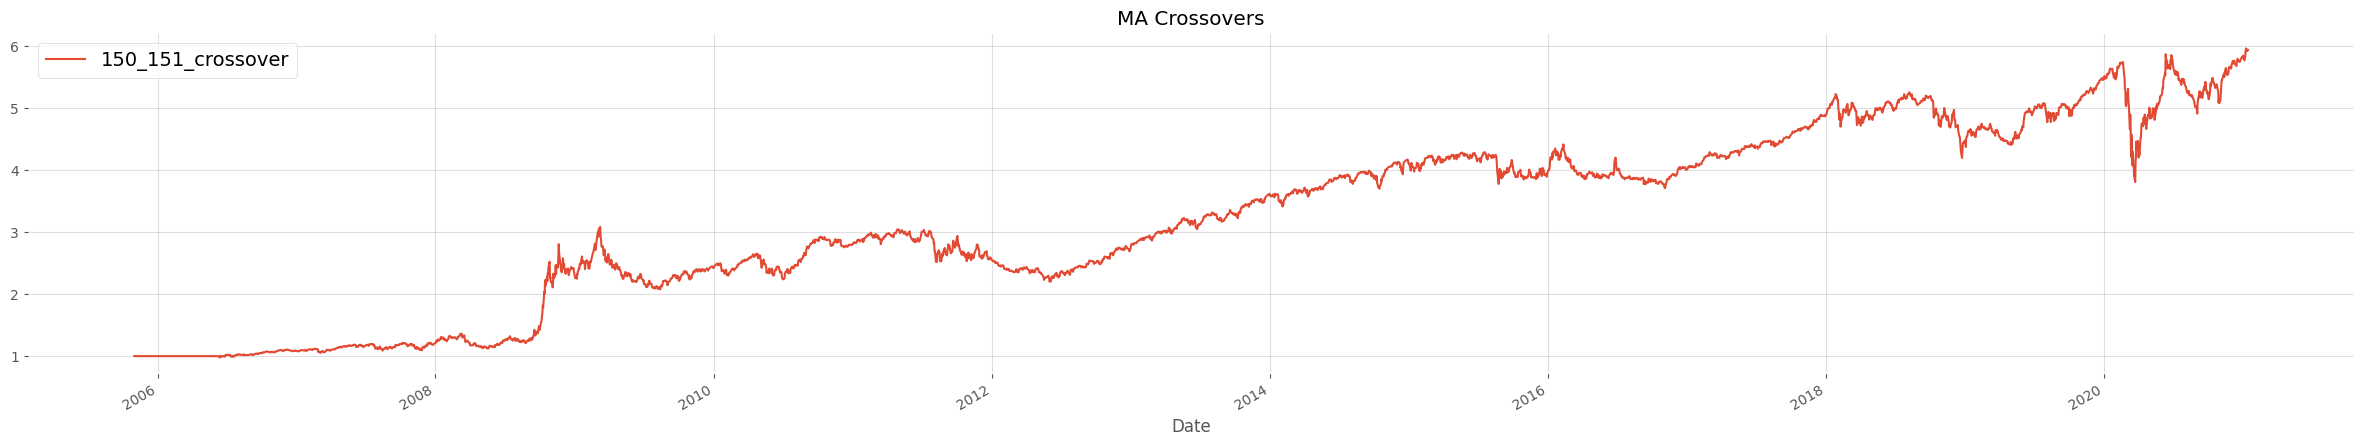

In [11]:
pd.DataFrame(crossovers_cum_ret, columns=[top_crossovers], index=ideation_index).plot()
plt.title("MA Crossovers");

> Full 20-Year Backtest

In [12]:
top_crossover = strategy_info(returns=SPY_returns.values.flatten())  # full SPY returns
short_index = int(int(top_crossovers.split("_")[0]) / step - 1)
long_index = int(int(top_crossovers.split("_")[1]) / step - 1)


top_crossover_position = compute_SMA_position(
    SPY_w_MA_indicator.values.T[1:], short_index, long_index
)

strat_name = f"{(short_index + 1)*step}_{(long_index + 1)*step}_crossover"

top_crossover.update(strat_name, top_crossover_position)

top_crossover_position, top_crossover_returns, top_crossover_cum_ret = (
    top_crossover.position_dict,
    top_crossover.returns_dict,
    top_crossover.cum_ret_dict,
)

top_crossover_final_ret = top_crossover.get_final_ret()

### <a id = "part1.1.2"></a><font color = orange> 📈 Passive Following </font> [back to Part 1](#part1)

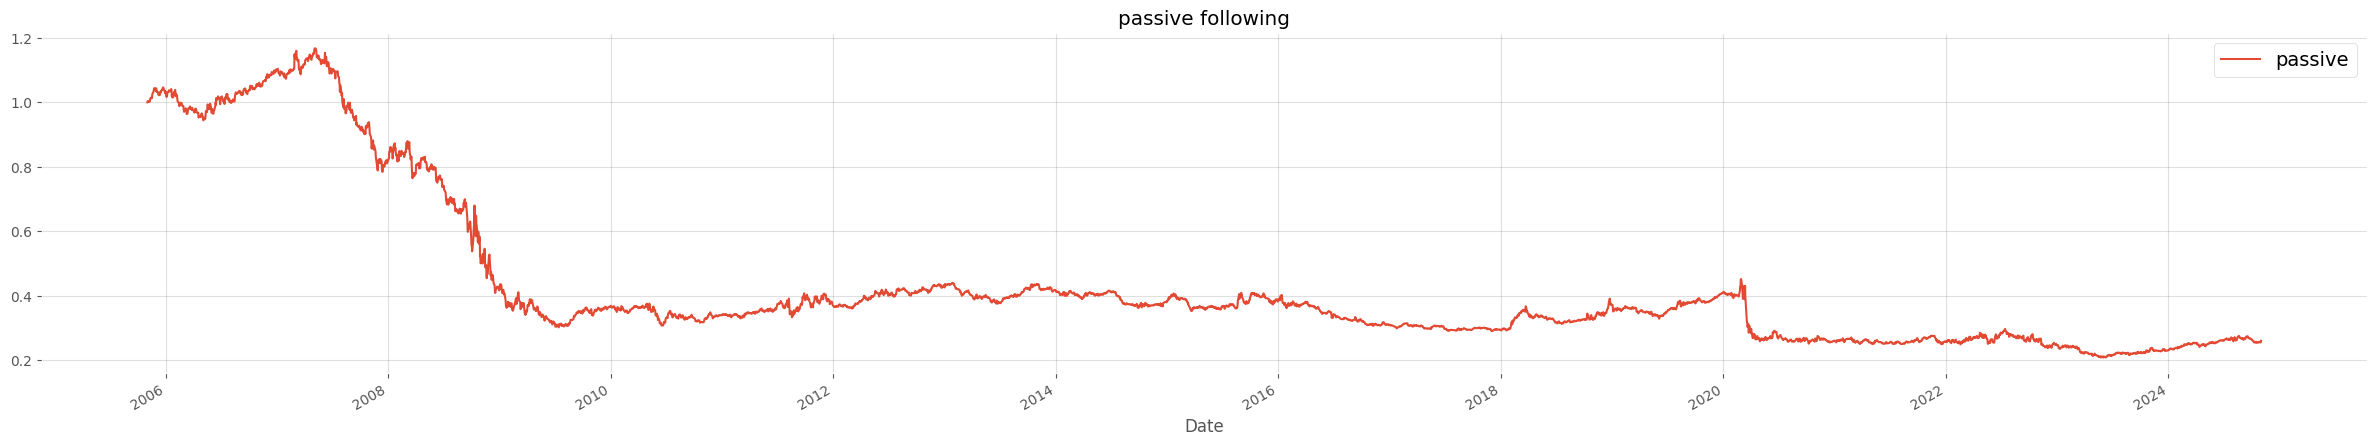

In [13]:
passive_following = strategy_info(returns=SPY_returns.values.flatten())

position = np.sign(SPY_returns.values.flatten())
position = np.roll(position, 1)
position[0] = 0

passive_following.update(name="passive", position=position)

passive_following_position, passive_following_returns, passive_following_cum_ret = (
    passive_following.position_dict,
    passive_following.returns_dict,
    passive_following.cum_ret_dict,
)

pd.DataFrame(
    passive_following_cum_ret, columns=["passive"], index=SPY_price.index
).plot()

plt.title("passive following");

### <a id = "part1.1.3"></a><font color = orange> 📈 RSI </font> [back to Part 1](#part1)

In [14]:
rsi_strat = strategy_info(returns=ideation_returns)

thresholds = [i for i in range(10, 50, 5)]

In [15]:
rsi_windows = [i for i in range(2, 100)]

for rsi_window in rsi_windows:
    SPY_indicator.compute("RSI", n=rsi_window)

SPY_RSI = SPY_indicator.df.to_pandas().set_index("Date")

In [16]:
def compute_rsi_position(rsi: pd.Series, threshold: int) -> np.array:
    rsi_up = rsi.diff() > 0
    rsi_down = rsi.diff() < 0

    crossed_upper = (
        np.sign((rsi - (100 - threshold)) * (rsi - (100 - threshold)).shift(1)).fillna(
            1
        )
        == -1
    )
    crossed_lower = (
        np.sign((rsi - threshold) * (rsi - threshold).shift(1)).fillna(1) == -1
    )

    # Generate trade signals
    buy = rsi_up & crossed_lower  # signals when RSI crosses 30 upwards
    sell = rsi_down & crossed_upper  # RSI crosses 70 downwards
    position_series = pd.Series(np.nan).reindex(rsi.index)

    position_series[buy] = 1
    position_series[sell] = -1

    position_series.iloc[0] = 0

    position = position_series.ffill().to_numpy()

    position = np.roll(position, 1)
    position[0] = 0

    return position

In [17]:
for rsi_window in rsi_windows:
    for threshold in thresholds:
        rsi = SPY_RSI[f"RSI_{rsi_window}_SPY"][SPY_RSI.index.isin(ideation_index)]

        position = compute_rsi_position(rsi=rsi, threshold=threshold)

        strat_name = f"RSI_{rsi_window}_{threshold}"
        rsi_strat.update(name=strat_name, position=position)

rsi_position, rsi_returns, rsi_cum_ret = (
    rsi_strat.position_dict,
    rsi_strat.returns_dict,
    rsi_strat.cum_ret_dict,
)

In [18]:
rsi_final_ret = rsi_strat.get_final_ret()

top_rsi = list(rsi_final_ret.keys())[0]

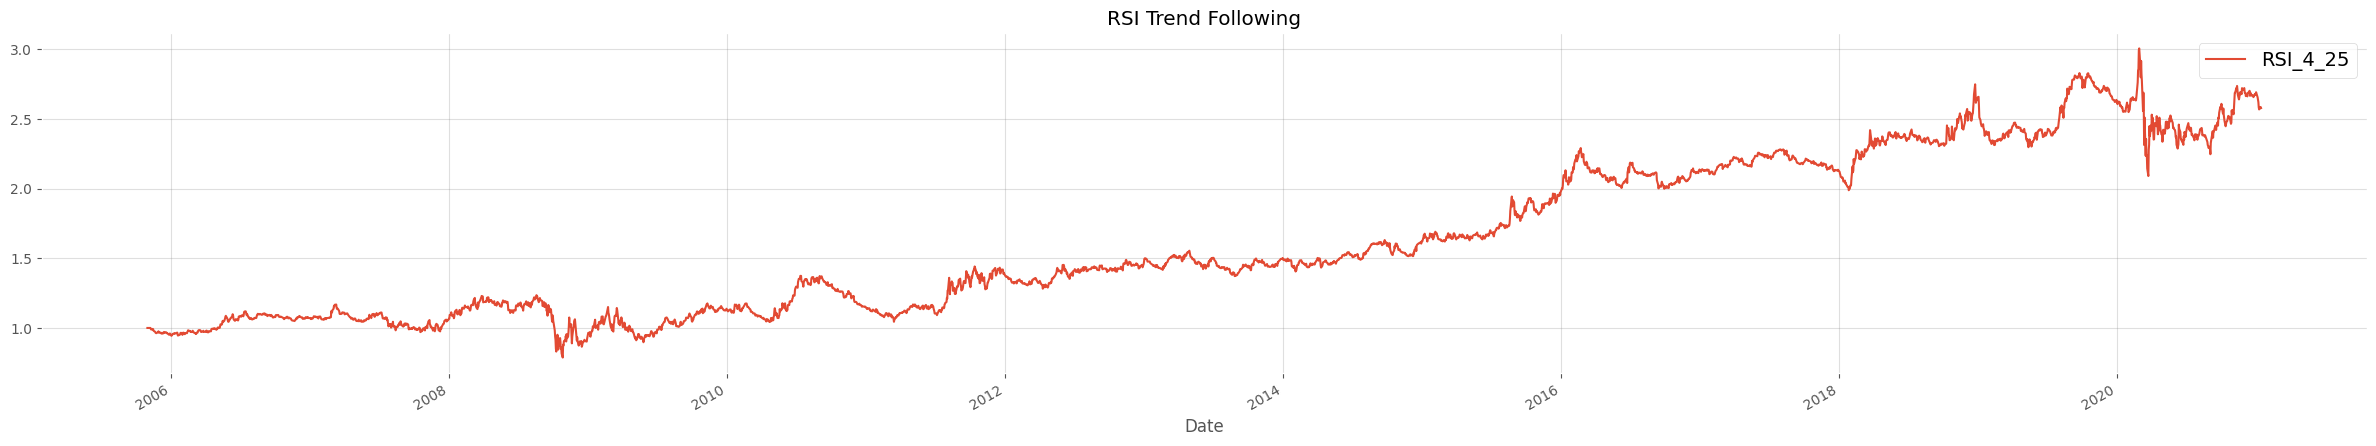

In [19]:
pd.DataFrame(
    rsi_cum_ret[top_rsi],
    columns=[top_rsi],
    index=ideation_index,
).plot(figsize=[30, 5])

plt.title("RSI Trend Following");

> Full 20-Year Backtest

In [20]:
top_rsi_strat = strategy_info(returns=SPY_returns.values.flatten())  # full SPY returns
rsi_window = int(top_rsi.split("_")[1])
threshold = int(top_rsi.split("_")[-1])


top_rsi_position = compute_rsi_position(
    rsi=SPY_RSI[f"RSI_{rsi_window}_SPY"], threshold=threshold
)

strat_name = f"RSI_{rsi_window}_{threshold}"

top_rsi_strat.update(strat_name, top_rsi_position)

top_rsi_position, top_rsi_returns, top_rsi_cum_ret = (
    top_rsi_strat.position_dict,
    top_rsi_strat.returns_dict,
    top_rsi_strat.cum_ret_dict,
)

top_rsi_final_ret = top_rsi_strat.get_final_ret()

### <a id = "meanreversion"></a><font color = blue> 🔁 Mean Reversion </font> [back to Part 1](#part1)

> Mean reversion means a tendency of asset prices to return to a trend path. Mean-reversion strategies are based on the opposite belief to momentum strategies—that is, if a financial instrument has performed too well relative to its trend, it is shorted, and vice versa. While time-series momentum strategies expect a positive correlation between returns, mean-reversion strategies anticipate a negative correlation.

    Mean-reversion strategy utilizes a simple moving average (SMA) as a proxy for a trend path. The key is to define a threshold for the distance between the current stock price and the SMA, which serves as a signal for a long or short position.

In [21]:
thresholds = range(2, 50, 1)
mean_reversion = strategy_info(returns=ideation_returns)

In [22]:
SPY_w_MR_indicator = SPY_indicator.df.to_pandas().set_index("Date")

for col in SPY_w_MR_indicator.columns[1:]:
    if "SMA" in col:
        SPY_w_MR_indicator[f"{col}_distance"] = (
            SPY_w_MR_indicator["SPY"] - SPY_w_MR_indicator[col]
        )
        SPY_w_MR_indicator = SPY_w_MR_indicator.drop(columns=col)

SPY_w_MR_indicator = SPY_w_MR_indicator[
    [col for col in SPY_w_MR_indicator if "distance" in col]
]

In [23]:
SPY_distance_array = SPY_w_MR_indicator[
    SPY_w_MR_indicator.index.isin(ideation_index)
].values.T

In [24]:
def compute_mean_reversion_position(
    array: np.array, window: int, threshold: int
) -> np.array:
    position = np.where(
        array[window] > threshold,
        -1,
        np.nan,
    )
    position = np.where(
        array[window] < -threshold,
        1,
        position,
    )
    for i in range(1, len(position)):
        if position[i] * position[i - 1] < 0:
            position[i] = 0

        if np.isnan(position[i]):
            position[i] = position[i - 1]

    position = np.nan_to_num(position, 0)

    return position

In [25]:
for window in range(len(SPY_w_MR_indicator.columns)):
    for threshold in thresholds:
        position = compute_mean_reversion_position(
            array=SPY_distance_array, window=window, threshold=threshold
        )
        strat_name = f"SMA_{(window + 1)*step}_{threshold}_MR"

        mean_reversion.update(name=strat_name, position=position)

mean_reversion_position, mean_reversion_returns, mean_reversion_cum_ret = (
    mean_reversion.position_dict,
    mean_reversion.returns_dict,
    mean_reversion.cum_ret_dict,
)

In [26]:
mean_reversion_final_ret = mean_reversion.get_final_ret()
top_mean_reversion = list(mean_reversion_final_ret.keys())[0]

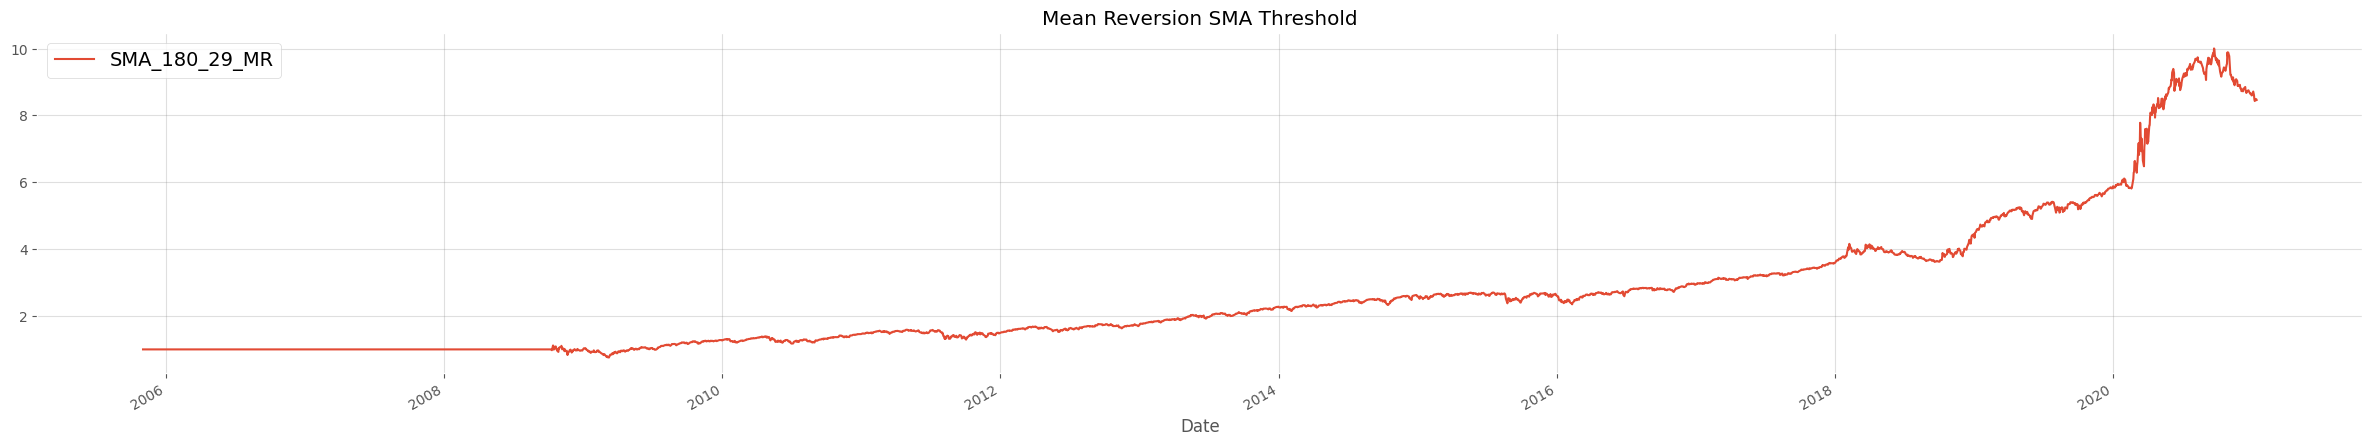

In [27]:
pd.DataFrame(
    mean_reversion_cum_ret[top_mean_reversion],
    columns=[top_mean_reversion],
    index=ideation_index,
).plot()

plt.title("Mean Reversion SMA Threshold");

> Full 20-Year Backtest

In [28]:
top_mean_reversion_strat = strategy_info(
    returns=SPY_returns.values.flatten()
)  # full SPY returns
window = int(int(top_mean_reversion.split("_")[1]) / step - 1)
threshold = int(top_mean_reversion.split("_")[2])


top_mean_reversion_position = compute_mean_reversion_position(
    array=SPY_w_MR_indicator.values.T, window=window, threshold=threshold
)

strat_name = f"SMA_{(window + 1)*step}_{threshold}_MR"

top_mean_reversion_strat.update(strat_name, top_mean_reversion_position)

top_mean_reversion_position, top_mean_reversion_returns, top_mean_reversion_cum_ret = (
    top_mean_reversion_strat.position_dict,
    top_mean_reversion_strat.returns_dict,
    top_mean_reversion_strat.cum_ret_dict,
)

top_mean_reversion_final_ret = top_mean_reversion_strat.get_final_ret()

### <a id = "ML"></a><font color = blue> ⚙️ Machine Learning </font> [back to Part 1](#part1)

In [29]:
# Loading Algorithm

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# ENSEMBLE

## Bagging
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

## Boosting
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Support Vector Machine
from sklearn.svm import LinearSVC

# K-Nearest Neighbor
from sklearn.neighbors import KNeighborsClassifier

# for data split
from sklearn.model_selection import train_test_split

# for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn.metrics import f1_score

# for feature engineering
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

### <a id = "FE"></a><font color = Orange> ⚙️ Feature Engineering </font> [back to Part 1](#part1)

# Classification Models

In [30]:
Y = np.sign(SPY_returns.shift(-1))  # we want to predict the next day's direction
Y = np.where(Y == 0, 1, Y)
Y = pd.DataFrame(Y, columns=["Y"], index=SPY_returns.index)

In [ ]:
rsi_windows = [i for i in range(2, 100)]
SMA_windows = [i for i in range(2, 100 + step, step)]

SPY_indicator_ml = indicators(df=SPY_price.reset_index(), tickers=[ticker])
SPY_indicator_ml.compute("SMA", windows=SMA_windows)
SPY_indicator_ml.compute("EWMA", spans=SMA_windows)

for rsi_window in rsi_windows:
    SPY_indicator_ml.compute("RSI", n=rsi_window)

for n in range(2, 100):
    SPY_indicator_ml.compute("MOM", n=n)
    SPY_indicator_ml.compute("ROC", n=n)
    SPY_indicator_ml.compute("MACD", short=12, long=26, signal=n)
    SPY_indicator_ml.compute(
        "STOK",
        close=SPY[["Close"]].rename(columns={"Close": "SPY"}),
        low=SPY[["Low"]].rename(columns={"Low": "SPY"}),
        high=SPY[["High"]].rename(columns={"High": "SPY"}),
        n=n,
    )
    SPY_indicator_ml.compute(
        "STOD",
        close=SPY[["Close"]].rename(columns={"Close": "SPY"}),
        low=SPY[["Low"]].rename(columns={"Low": "SPY"}),
        high=SPY[["High"]].rename(columns={"High": "SPY"}),
        n=n,
    )

X = SPY_indicator_ml.df.clone()

X = X.to_pandas().set_index("Date")

X

,SPY,SMA_2_SPY,SMA_3_SPY,SMA_4_SPY,SMA_5_SPY,SMA_6_SPY,SMA_7_SPY,SMA_8_SPY,SMA_9_SPY,SMA_10_SPY,...,MACD_12_26_98_SPY,signal_line_12_26_98_SPY,STOK_98_SPY,STOD_98_SPY,MOM_99_SPY,ROC_99_SPY,MACD_12_26_99_SPY,signal_line_12_26_99_SPY,STOK_99_SPY,STOD_99_SPY
Date,,,,,,,,,,,,,,,,,,,,,
2005-11-01,83.991,83.991,83.991,83.991,83.991,83.991,83.991,83.991,83.991,83.991,...,0.000,0.000,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN
2005-11-02,84.869,84.430,84.430,84.430,84.430,84.430,84.430,84.430,84.430,84.430,...,0.020,0.010,NaN,NaN,NaN,NaN,0.020,0.010,NaN,NaN
2005-11-03,85.232,85.051,84.698,84.698,84.698,84.698,84.698,84.698,84.698,84.698,...,0.036,0.019,NaN,NaN,NaN,NaN,0.036,0.019,NaN,NaN
2005-11-04,85.120,85.176,85.074,84.803,84.803,84.803,84.803,84.803,84.803,84.803,...,0.039,0.024,NaN,NaN,NaN,NaN,0.039,0.024,NaN,NaN
2005-11-07,85.204,85.162,85.185,85.106,84.883,84.883,84.883,84.883,84.883,84.883,...,0.043,0.028,NaN,NaN,NaN,NaN,0.043,0.028,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-25,579.040,579.140,578.757,579.897,580.644,581.302,581.451,581.557,581.360,581.656,...,4.664,3.931,90.666,90.292,47.719,0.090,4.664,3.926,90.666,90.292
2024-10-28,580.830,579.935,579.703,579.275,580.084,580.675,581.234,581.374,581.477,581.307,...,4.432,3.941,93.026,91.540,49.519,0.095,4.432,3.936,93.026,91.540
2024-10-29,581.770,581.300,580.547,580.220,579.774,580.365,580.831,581.301,581.418,581.506,...,4.275,3.948,94.265,92.652,51.105,0.093,4.275,3.943,94.265,92.652


In [32]:
data = pd.concat([Y, X], axis=1).dropna()
Y = data.loc[:, "Y"]
X = data.loc[:, X.columns].drop(columns="SPY")

X.head()

,SMA_2_SPY,SMA_3_SPY,SMA_4_SPY,SMA_5_SPY,SMA_6_SPY,SMA_7_SPY,SMA_8_SPY,SMA_9_SPY,SMA_10_SPY,SMA_11_SPY,...,MACD_12_26_98_SPY,signal_line_12_26_98_SPY,STOK_98_SPY,STOD_98_SPY,MOM_99_SPY,ROC_99_SPY,MACD_12_26_99_SPY,signal_line_12_26_99_SPY,STOK_99_SPY,STOD_99_SPY
Date,,,,,,,,,,,,,,,,,,,,,
2006-03-28,91.196,91.334,91.386,91.455,91.408,91.457,91.512,91.547,91.555,91.526,...,0.435,0.302,77.319,83.864,6.045,0.067,0.435,0.302,77.319,84.474
2006-03-29,91.199,91.292,91.372,91.405,91.459,91.419,91.460,91.509,91.540,91.549,...,0.424,0.305,85.185,82.629,6.252,0.075,0.424,0.305,85.484,83.339
2006-03-30,91.403,91.240,91.299,91.362,91.391,91.440,91.407,91.445,91.490,91.521,...,0.397,0.307,82.819,81.774,6.202,0.072,0.397,0.307,82.819,81.874
2006-03-31,91.333,91.383,91.266,91.308,91.359,91.385,91.428,91.400,91.435,91.477,...,0.373,0.308,83.128,83.711,6.139,0.072,0.373,0.308,83.128,83.810
2006-04-03,91.308,91.313,91.356,91.267,91.302,91.346,91.371,91.411,91.387,91.420,...,0.344,0.309,82.099,82.682,6.069,0.070,0.344,0.309,82.099,82.682


In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=(1 - prop), random_state=random_state, shuffle=False
)

scaler = StandardScaler().fit(X_train)  # Fit on X train to avoid look ahead
rescaled_X_train = pd.DataFrame(
    scaler.transform(X_train), columns=X_train.columns, index=X_train.index
)
rescaled_X_test = pd.DataFrame(
    scaler.transform(X_test), columns=X_test.columns, index=X_test.index
)

scoring = "f1"

In [34]:
ncomps = 20

svd = TruncatedSVD(n_components=ncomps, random_state=random_state)

svd_fit = svd.fit(rescaled_X_train)

print(
    f"Variance preserved by first {ncomps} components == {svd_fit.explained_variance_ratio_.cumsum()[-1]:.2%}"
)

svd_X_train = svd_fit.transform(rescaled_X_train)
svd_X_test = svd_fit.transform(rescaled_X_test)

Variance preserved by first 20 components == 97.82%


In [35]:
svd_X_train = pd.DataFrame(
    svd_X_train,
    columns=["pc{}".format(c) for c in range(ncomps)],
    index=rescaled_X_train.index,
)

svd_X_test = pd.DataFrame(
    svd_X_test,
    columns=["pc{}".format(c) for c in range(ncomps)],
    index=rescaled_X_test.index,
)


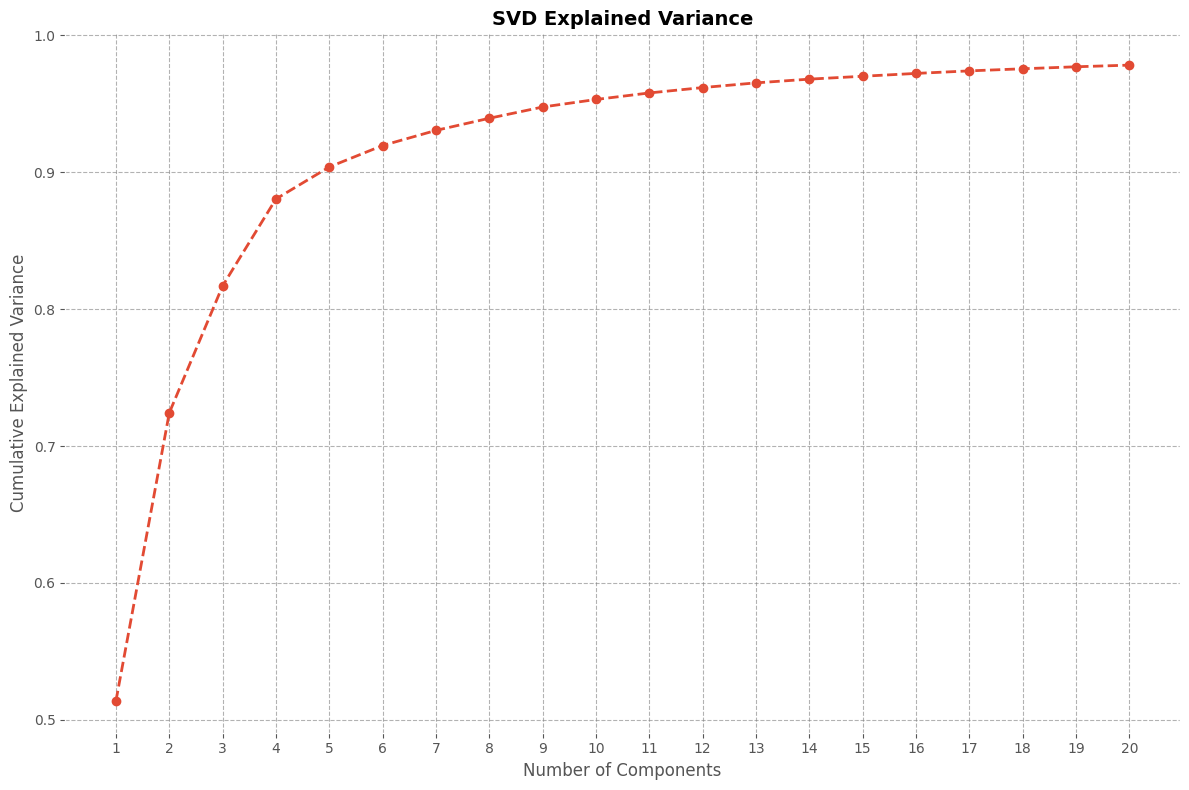

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(
    np.arange(1, len(svd_fit.explained_variance_ratio_) + 1),
    np.cumsum(svd_fit.explained_variance_ratio_),
    marker="o",
    linestyle="--",
    linewidth=2,
)

plt.xlabel("Number of Components", fontsize=12)
plt.ylabel("Cumulative Explained Variance", fontsize=12)
plt.title("SVD Explained Variance", fontsize=14, fontweight="bold")
plt.xticks(
    ticks=np.arange(1, len(svd_fit.explained_variance_ratio_) + 1),
    labels=np.arange(1, len(svd_fit.explained_variance_ratio_) + 1),
    fontsize=10,
)
plt.yticks(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### <a id = "Baseline"></a><font color = Orange> ⚙️ Baseline Models </font> [back to Part 1](#part1)

In [37]:
baseline_models = []

baseline_models.append(("CART_C", DecisionTreeClassifier(random_state=random_state)))

baseline_models.append(("KNN_C", KNeighborsClassifier(n_jobs=-1)))

baseline_models.append(("SVC_C", LinearSVC(random_state=random_state)))

baseline_models.append(
    ("RFC_C", RandomForestClassifier(n_jobs=-1, random_state=random_state))
)

baseline_models.append(
    ("ETC_C", ExtraTreesClassifier(n_jobs=-1, random_state=random_state))
)

baseline_models.append(("GBC_C", GradientBoostingClassifier(random_state=random_state)))

baseline_models.append(("ABC_C", AdaBoostClassifier(random_state=random_state)))

In [38]:
names = []

kfold_results = []

train_results = []
test_results = []

for name, model in baseline_models:
    names.append(name)

    kfold = KFold(n_splits=numfolds, random_state=random_state, shuffle=True)

    cv_results = cross_val_score(
        model, svd_X_train, Y_train, cv=kfold, scoring=scoring, n_jobs=-1
    )

    kfold_results.append(cv_results)

    res = model.fit(svd_X_train, Y_train)

    train_result = f1_score(res.predict(svd_X_train), Y_train)

    train_results.append(train_result)

    test_result = f1_score(res.predict(svd_X_test), Y_test)

    test_results.append(test_result)
    message = "%s: %f (%f) %f %f" % (
        name,
        cv_results.mean(),
        cv_results.std(),
        train_result,
        test_result,
    )
    print(message)

CART_C: 0.550970 (0.028805) 1.000000 0.508682
KNN_C: 0.590626 (0.022518) 0.747388 0.555344
SVC_C: 0.706653 (0.028975) 0.713194 0.698611
RFC_C: 0.616794 (0.026411) 1.000000 0.576819
ETC_C: 0.599341 (0.030612) 1.000000 0.619863
GBC_C: 0.649211 (0.027716) 0.784760 0.654028
ABC_C: 0.630482 (0.017129) 0.714007 0.615257


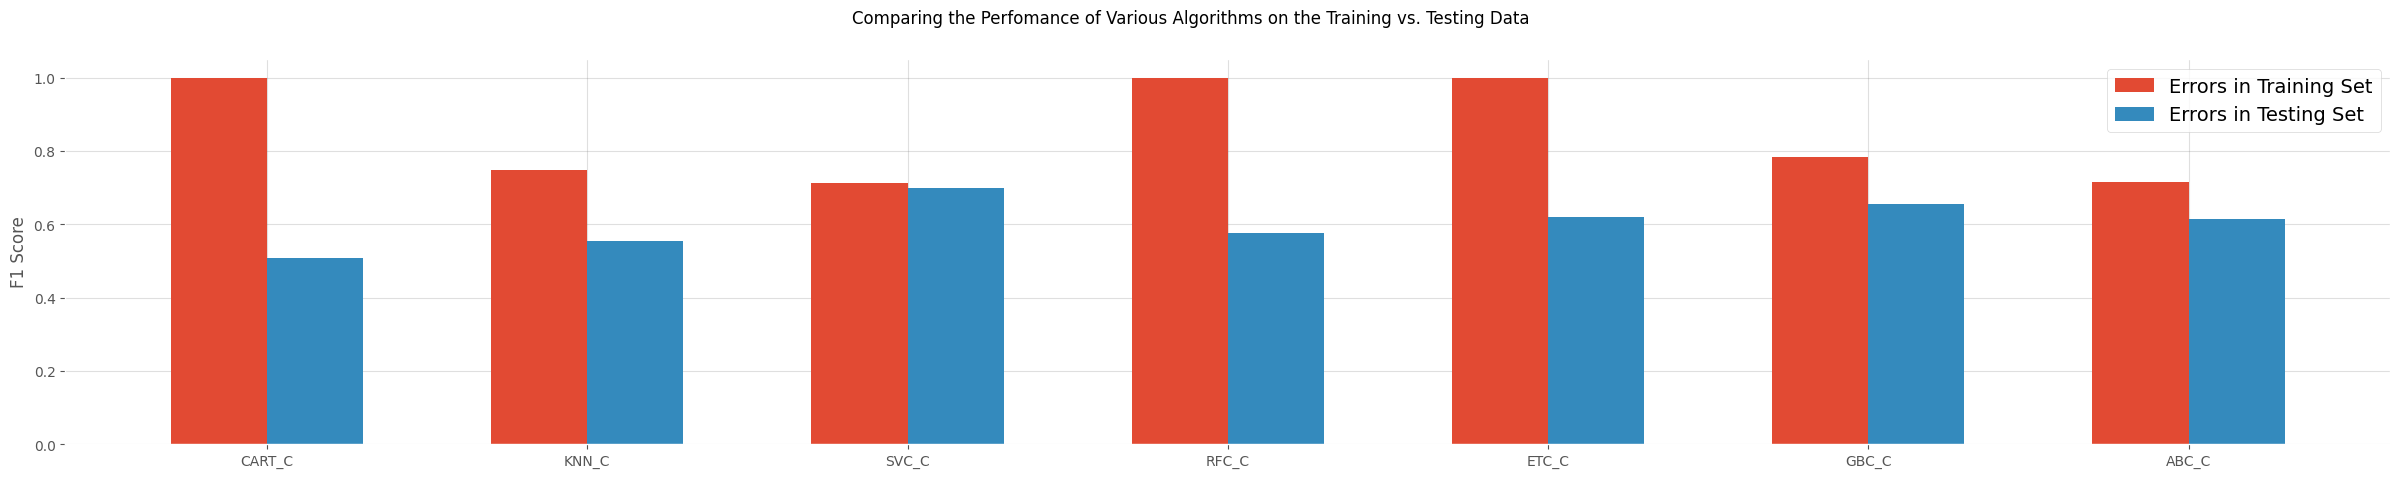

In [39]:
fig = plt.figure()

ind = np.arange(len(names))

width = 0.30

fig.suptitle(
    "Comparing the Perfomance of Various Algorithms on the Training vs. Testing Data"
)

ax = fig.add_subplot(111)

plt.bar(
    ind - width / 2,
    train_results,
    width=width,
    label="Errors in Training Set",
)

(plt.bar(ind + width / 2, test_results, width=width, label="Errors in Testing Set"))

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.ylabel("F1 Score")

plt.show()

> Full 20-Year Backtest

In [40]:
ml_strat = strategy_info(returns=SPY_returns.values.flatten())

full_X = pd.DataFrame(
    scaler.transform(X),
    columns=X.columns,
    index=X.index,
)

svd_full_X = svd_fit.transform(full_X)


for name, model in baseline_models:
    model.fit(svd_X_train, Y_train)

    position = pd.DataFrame()
    position.index = full_X.index

    position["position"] = model.predict(svd_full_X)

    position = SPY_returns.merge(
        position, how="left", left_index=True, right_index=True
    ).fillna(0)

    position = position["position"].values.flatten()

    position = np.roll(position, 1)
    position[0] = 0

    ml_strat.update(name=f"baseline_{name}", position=position)

ml_position, ml_returns, ml_cum_ret = (
    ml_strat.position_dict,
    ml_strat.returns_dict,
    ml_strat.cum_ret_dict,
)

ml_final_ret = ml_strat.get_final_ret()

### <a id = "Tuning"></a><font color = Orange> ⚙️ Tuning Models </font> [back to Part 1](#part1)

In [41]:
tune_models = []

tune_models.append(("CART_C", DecisionTreeClassifier))

tune_models.append(("KNN_C", KNeighborsClassifier))

tune_models.append(("SVC_C", LinearSVC))

tune_models.append(("RFC_C", RandomForestClassifier))

tune_models.append(("ETC_C", ExtraTreesClassifier))

tune_models.append(("GBC_C", GradientBoostingClassifier))

tune_models.append(("ABC_C", AdaBoostClassifier))

In [42]:
n_estimator = [i for i in range(50, 500, 50)]

model_params = {
    "CART_C": {
        "criterion": ["gini", "entropy"],
        "random_state": [random_state],
    },
    "KNN_C": {
        "n_neighbors": [i for i in range(3, 21)],
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree"],
        "n_jobs": [-1],
    },
    "SVC_C": {
        "C": [0.1, 1, 10, 100],
        "penalty": ["l1", "l2"],
        "random_state": [random_state],
    },
    "RFC_C": {
        "n_estimators": n_estimator,
        "random_state": [random_state],
        "n_jobs": [-1],
    },
    "ETC_C": {
        "n_estimators": n_estimator,
        "random_state": [random_state],
        "n_jobs": [-1],
    },
    "GBC_C": {
        "n_estimators": n_estimator,
    },
    "ABC_C": {
        "n_estimators": n_estimator,
        "algorithm": ["SAMME", "SAMME.R"],
        "random_state": [random_state],
    },
}

grid_search_params = model_params.copy()

> Full 20-Year Backtest

In [43]:
ml_strat_tuned = strategy_info(returns=SPY_returns.values.flatten())

for name, model in tune_models:
    print(f"tuning {name}")
    search = GridSearchCV(
        model(), model_params[name], n_jobs=-1, cv=numfolds, scoring=scoring, verbose=2
    )
    search.fit(svd_X_train, Y_train)

    params = search.best_params_
    grid_search_params[name] = params

    model = model(**params)
    model.fit(svd_X_train, Y_train)

    position = pd.DataFrame()
    position.index = full_X.index

    position["position"] = model.predict(svd_full_X)

    position = SPY_returns.merge(
        position, how="left", left_index=True, right_index=True
    ).fillna(0)

    position = position["position"].values.flatten()

    position = np.roll(position, 1)
    position[0] = 0

    ml_strat_tuned.update(name=f"tuned_{name}", position=position)

ml_tuned_position, ml_tuned_returns, ml_tuned_cum_ret = (
    ml_strat_tuned.position_dict,
    ml_strat_tuned.returns_dict,
    ml_strat_tuned.cum_ret_dict,
)

ml_tuned_final_ret = ml_strat_tuned.get_final_ret()

tuning CART_C
Fitting 10 folds for each of 2 candidates, totalling 20 fits
tuning KNN_C
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
tuning SVC_C
Fitting 10 folds for each of 8 candidates, totalling 80 fits
tuning RFC_C
Fitting 10 folds for each of 9 candidates, totalling 90 fits
tuning ETC_C
Fitting 10 folds for each of 9 candidates, totalling 90 fits
tuning GBC_C
Fitting 10 folds for each of 9 candidates, totalling 90 fits
tuning ABC_C
Fitting 10 folds for each of 18 candidates, totalling 180 fits


In [44]:
grid_search_params

{'CART_C': {'criterion': 'entropy', 'random_state': 627},
 'KNN_C': {'algorithm': 'auto',
  'n_jobs': -1,
  'n_neighbors': 19,
  'weights': 'uniform'},
 'SVC_C': {'C': 0.1, 'penalty': 'l1', 'random_state': 627},
 'RFC_C': {'n_estimators': 450, 'n_jobs': -1, 'random_state': 627},
 'ETC_C': {'n_estimators': 400, 'n_jobs': -1, 'random_state': 627},
 'GBC_C': {'n_estimators': 50},
 'ABC_C': {'algorithm': 'SAMME', 'n_estimators': 50, 'random_state': 627}}

# Regression Models

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
)
from sklearn.svm import SVR

baseline_models_regress = [
    ("LR_R", LinearRegression()),
    ("LASSO_R", Lasso()),
    ("EN_R", ElasticNet()),
    ("CART_R", DecisionTreeRegressor(random_state=random_state)),
    ("KNN_R", KNeighborsRegressor()),
    ("SVR_R", SVR()),
    ("RFR_R", RandomForestRegressor(random_state=random_state)),
    ("ETR_R", ExtraTreesRegressor(random_state=random_state)),
    ("GBR_R", GradientBoostingRegressor(random_state=random_state)),
    ("ABR_R", AdaBoostRegressor(random_state=random_state)),
]

LR_R: 0.998946 (0.008948) 0.992204 1.006355 
LASSO_R: 0.994126 (0.008218) 0.993506 0.998093 
EN_R: 0.994126 (0.008218) 0.993506 0.998093 
CART_R: 1.407580 (0.023132) 0.000000 1.432956 
KNN_R: 1.077883 (0.018082) 0.876717 1.108885 
SVR_R: 1.209554 (0.054491) 1.171469 1.119325 
RFR_R: 1.021288 (0.008429) 0.380859 1.015690 
ETR_R: 1.043941 (0.016651) 0.000000 1.019526 
GBR_R: 1.013176 (0.009193) 0.908639 1.034130 
ABR_R: 1.009555 (0.013410) 0.995215 1.024382 


C:\Users\zk_me\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zk_me\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zk_me\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zk_me\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

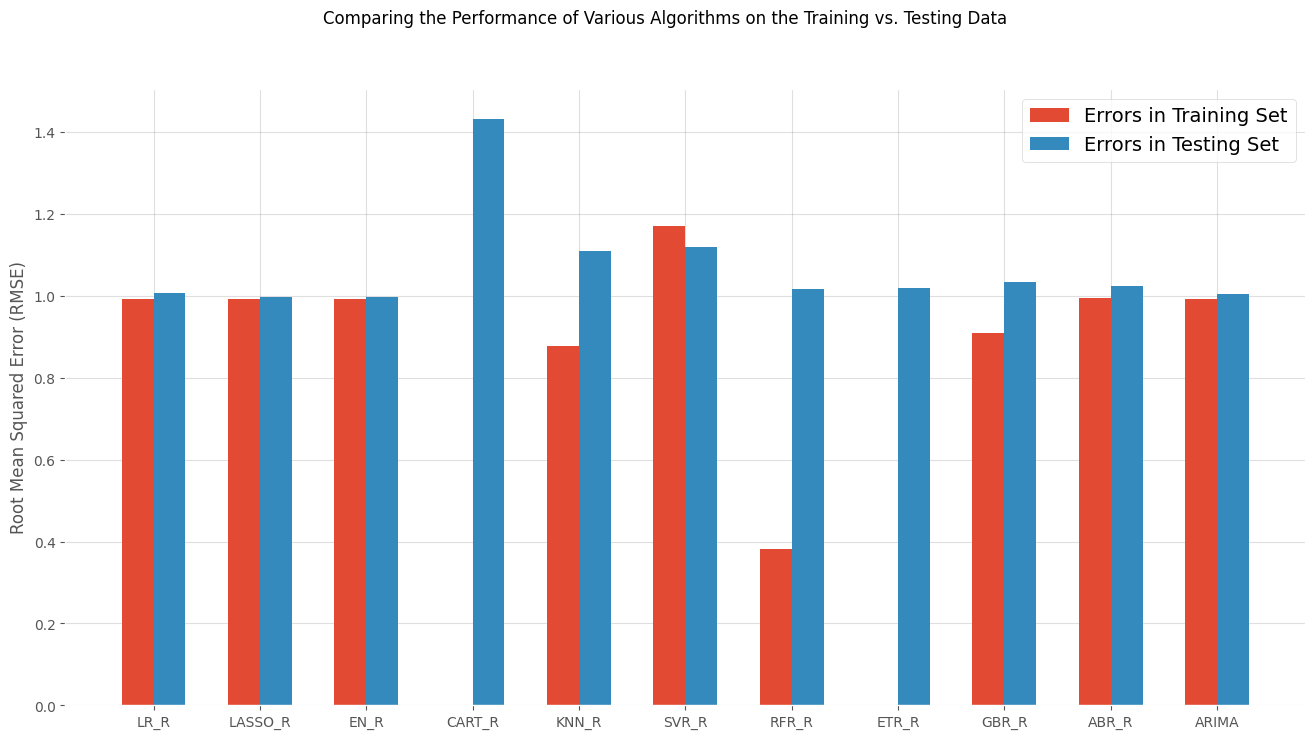

In [ ]:
names_regress = []
kfold_results_regress = []
train_results_regress = []
test_results_regress = []

svd_X_train_regress = svd_X_train
svd_X_test_regress = svd_X_test
Y_train_regress = Y_train
Y_test_regress = Y_test

for name, model in baseline_models_regress:
    names_regress.append(name)
    kfold = KFold(n_splits=numfolds, random_state=random_state, shuffle=True)
    cv_results_regress = np.sqrt(
        -cross_val_score(
            model,
            svd_X_train_regress,
            Y_train_regress,
            cv=kfold,
            scoring="neg_mean_squared_error",
        )
    )
    kfold_results_regress.append(cv_results_regress)
    res_regress = model.fit(svd_X_train_regress, Y_train_regress)
    train_result_regress = np.sqrt(
        mean_squared_error(res_regress.predict(svd_X_train_regress), Y_train_regress)
    )
    train_results_regress.append(train_result_regress)
    test_result_regress = np.sqrt(
        mean_squared_error(res_regress.predict(svd_X_test_regress), Y_test_regress)
    )
    test_results_regress.append(test_result_regress)
    message = "%s: %f (%f) %f %f " % (
        name,
        cv_results_regress.mean(),
        cv_results_regress.std(),
        train_result_regress,
        test_result_regress,
    )
    print(message)

# ARIMA model setup
X_train_ARIMA = svd_X_train_regress
X_test_ARIMA = svd_X_test_regress
train_len = len(X_train_ARIMA)
test_len = len(X_test_ARIMA)
total_len = len(X)

# Fit ARIMA with the optimal order
modelARIMA = ARIMA(endog=Y_train_regress, exog=X_train_ARIMA, order=[3, 0, 0])
model_fit = modelARIMA.fit()
error_training_ARIMA = np.sqrt(
    mean_squared_error(Y_train_regress, model_fit.fittedvalues)
)
predicted = model_fit.predict(
    start=train_len - 1, end=total_len - 1, exog=X_test_ARIMA
)[1:]
error_testing_ARIMA = np.sqrt(mean_squared_error(Y_test_regress, predicted))

test_results_regress.append(error_testing_ARIMA)
train_results_regress.append(error_training_ARIMA)
names_regress.append("ARIMA")

# Plot comparison of model performance
fig = plt.figure(figsize=[16, 8])
width = 0.30
fig.suptitle(
    "Comparing the Performance of Various Algorithms on the Training vs. Testing Data"
)
ax = fig.add_subplot(111)
ind = np.arange(len(names_regress))
plt.bar(
    ind - width / 2,
    np.array(train_results_regress),
    width=width,
    label="Errors in Training Set",
)
plt.bar(
    ind + width / 2,
    np.array(test_results_regress),
    width=width,
    label="Errors in Testing Set",
)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names_regress)
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.show()

pd.options.display.float_format = "{:.6f}".format

# Display results in a DataFrame
results_df = pd.DataFrame(
    {
        "Model": names_regress,
        "Train_RMSE": train_results_regress,
        "Test_RMSE": test_results_regress,
    }
)

In [ ]:
# for regress models
ml_strat_regress = strategy_info(returns=SPY_returns.values.flatten())

full_X_regress = full_X

svd_full_X_regress = svd_full_X

for name, model in baseline_models_regress:
    model = model
    model.fit(svd_X_train_regress, Y_train_regress)

    position_r = pd.DataFrame()
    position_r.index = full_X_regress.index

    position_r["position"] = np.where(
        np.sign(model.predict(svd_full_X_regress)) == 0,
        1,
        np.sign(model.predict(svd_full_X_regress)),
    )

    position_r = SPY_returns.merge(
        position_r, how="left", left_index=True, right_index=True
    ).fillna(0)

    position_r = position_r["position"].values.flatten()

    position_r = np.roll(position_r, 1)
    position_r[0] = 0

    ml_strat_regress.update(name=f"baseline_{name}", position=position_r)

ml_position_regress, ml_returns_regress, ml_cum_ret_regress = (
    ml_strat_regress.position_dict,
    ml_strat_regress.returns_dict,
    ml_strat_regress.cum_ret_dict,
)

ml_final_ret_regress = ml_strat_regress.get_final_ret()

## <a id = "part2"></a><font color = blue> 👉 Part 2: Performance</font> [back to table of contents](#top)

In [48]:
strategies_positions = {}
strategies_returns = {}

for i in [
    top_crossover_position,
    top_mean_reversion_position,
    passive_following_position,
    top_rsi_position,
    ml_position,
    ml_position_regress,
    ml_tuned_position,
]:
    strategies_positions.update(i)

for i in [
    {"baseline": SPY_returns.values.flatten()},
    top_crossover_returns,
    top_mean_reversion_returns,
    passive_following_returns,
    top_rsi_returns,
    ml_returns,
    ml_returns_regress,
    ml_tuned_returns,
]:
    strategies_returns.update(i)

In [ ]:
periods = {
    "In Sample": ideation_index,
    "Out of Sample": testing_index,
    "Whole Period": np.concatenate([ideation_index, testing_index]),
}


def append_metrics(
    strategies: list[str],
    returns: dict[str, np.array],
    metrics: dict,
    filter_period: np.array,
) -> dict:
    for i in strategies:
        strat = pd.DataFrame(returns[i], columns=["returns"], index=SPY_price.index)
        strat = strat[strat.index.isin(filter_period)]
        perf = performance(df=strat, trading_days=252, return_type="log")
        metrics["strategy"].append(i)
        metrics["sharpe"].append(perf.sharpe(return_type="geometric"))
        metrics["max_dd %"].append(min(perf.drawdown()["Max Drawdown"]) * 100)
        metrics["annualized_returns %"].append(
            perf.annualized_returns(return_type="geometric") * 100
        )
        metrics["final_amount"].append(perf.final_amount() * capital)
        metrics["VaR"].append(
            perf.parametric_var(return_type="geometric", confidence=0.999) * capital
        )  # / (perf.final_amount() * capital)
        metrics["CAGR"].append(perf.CAGR())

    return metrics


for period, index in periods.items():
    metrics = {
        "strategy": [],
        "sharpe": [],
        "max_dd %": [],
        "annualized_returns %": [],
        "final_amount": [],
        "CAGR": [],
        "VaR": [],
    }

    metrics = append_metrics(
        strategies=["baseline", "passive", top_crossovers, top_mean_reversion, top_rsi]
        + list(ml_final_ret.keys())
        + list(ml_final_ret_regress.keys())
        + list(ml_tuned_final_ret.keys()),
        returns=strategies_returns,
        metrics=metrics,
        filter_period=index,
    )

    print(period)
    all_strategies_metrics = pd.DataFrame.from_dict(metrics).sort_values(
        by="final_amount", ascending=False
    )
    display(all_strategies_metrics)

In Sample


,strategy,sharpe,max_dd %,annualized_returns %,final_amount,CAGR,VaR
14,baseline_CART_R,38.018962,0.000000,599.125583,664496588568411392.000000,5.965901,550427.850780
7,baseline_CART_C,38.018962,0.000000,599.125583,664496588568411392.000000,5.965901,550427.850780
24,tuned_RFC_C,38.018962,0.000000,599.125583,664496588568411392.000000,5.965901,550427.850780
13,baseline_RFR_R,38.018962,0.000000,599.125583,664496588568411392.000000,5.965901,550427.850780
12,baseline_ETR_R,38.018962,0.000000,599.125583,664496588568411392.000000,5.965901,550427.850780
23,tuned_ETC_C,38.018962,0.000000,599.125583,664496588568411392.000000,5.965901,550427.850780
22,tuned_CART_C,38.018962,0.000000,599.125583,664496588568411392.000000,5.965901,550427.850780
6,baseline_RFC_C,38.018962,0.000000,599.125583,664496588568411392.000000,5.965901,550427.850780
5,baseline_ETC_C,38.018962,0.000000,599.125583,664496588568411392.000000,5.965901,550427.850780
8,baseline_GBC_C,7.783420,-11.769469,148.790752,102274873716.319214,1.483675,89716.719975


Out of Sample


,strategy,sharpe,max_dd %,annualized_returns %,final_amount,CAGR,VaR
5,baseline_ETC_C,1.402652,-16.848546,23.283789,220466.132047,0.231454,-28013.535413
8,baseline_GBC_C,1.154099,-19.061176,19.175825,195233.765400,0.192661,-32169.637396
22,tuned_CART_C,0.996511,-25.874212,16.566095,178249.462860,0.164415,-34806.218472
12,baseline_ETR_R,0.847589,-21.803634,14.096568,164341.987969,0.139769,-37298.262570
23,tuned_ETC_C,0.811519,-29.696729,13.498002,161095.146206,0.133795,-37901.840755
15,baseline_GBR_R,0.777048,-21.103729,12.925806,159148.514533,0.130171,-38478.660464
0,baseline,0.770372,-24.496399,12.814965,158556.722682,0.129063,-38590.377231
27,tuned_SVC_C,0.770372,-24.496399,12.814965,158556.722682,0.129063,-38590.377231
21,baseline_EN_R,0.770372,-24.496399,12.814965,158556.722682,0.129063,-38590.377231
20,baseline_LASSO_R,0.770372,-24.496399,12.814965,158556.722682,0.129063,-38590.377231


Whole Period


,strategy,sharpe,max_dd %,annualized_returns %,final_amount,CAGR,VaR
5,baseline_ETC_C,23.861915,-16.848546,394.183670,1470138566248628992.000000,3.927418,343134.996538
22,tuned_CART_C,23.467908,-25.874212,388.679005,1188624335769858560.000000,3.872631,337498.114223
12,baseline_ETR_R,23.318998,-21.803634,386.591508,1095884852357862144.000000,3.851855,335360.422560
23,tuned_ETC_C,23.282559,-29.696729,386.080102,1074233874718374272.000000,3.846765,334836.715338
13,baseline_RFR_R,23.152995,-19.399182,384.259792,1000410914937713280.000000,3.828647,332972.604093
6,baseline_RFC_C,23.086032,-22.973980,383.317826,964122442650466816.000000,3.819272,332007.963035
24,tuned_RFC_C,22.499755,-38.173431,375.036675,694549357189241856.000000,3.736849,323527.206159
14,baseline_CART_R,22.314221,-32.566693,372.403172,625011829274443008.000000,3.710636,320830.127720
7,baseline_CART_C,22.314221,-32.566693,372.403172,625011829274443008.000000,3.710636,320830.127720
8,baseline_GBC_C,6.124788,-19.061176,114.749300,198975795713.395660,1.144493,56853.094826


## <a id = "part3"></a><font color = blue> 👉 Part 3: Top 3 Strategies</font> [back to table of contents](#top)

In [ ]:
metrics = {
    "strategy": [],
    "sharpe": [],
    "max_dd %": [],
    "annualized_returns %": [],
    "final_amount": [],
    "VaR": [],
    "CAGR": [],
}

metrics = append_metrics(
    strategies=["baseline", "passive", top_crossovers, top_mean_reversion, top_rsi]
    + list(ml_final_ret.keys())
    + list(ml_tuned_final_ret.keys()),
    returns=strategies_returns,
    metrics=metrics,
    filter_period=testing_index,
)

all_strategies_metrics = pd.DataFrame.from_dict(metrics).sort_values(
    by="final_amount", ascending=False
)

<Axes: xlabel='Date'>

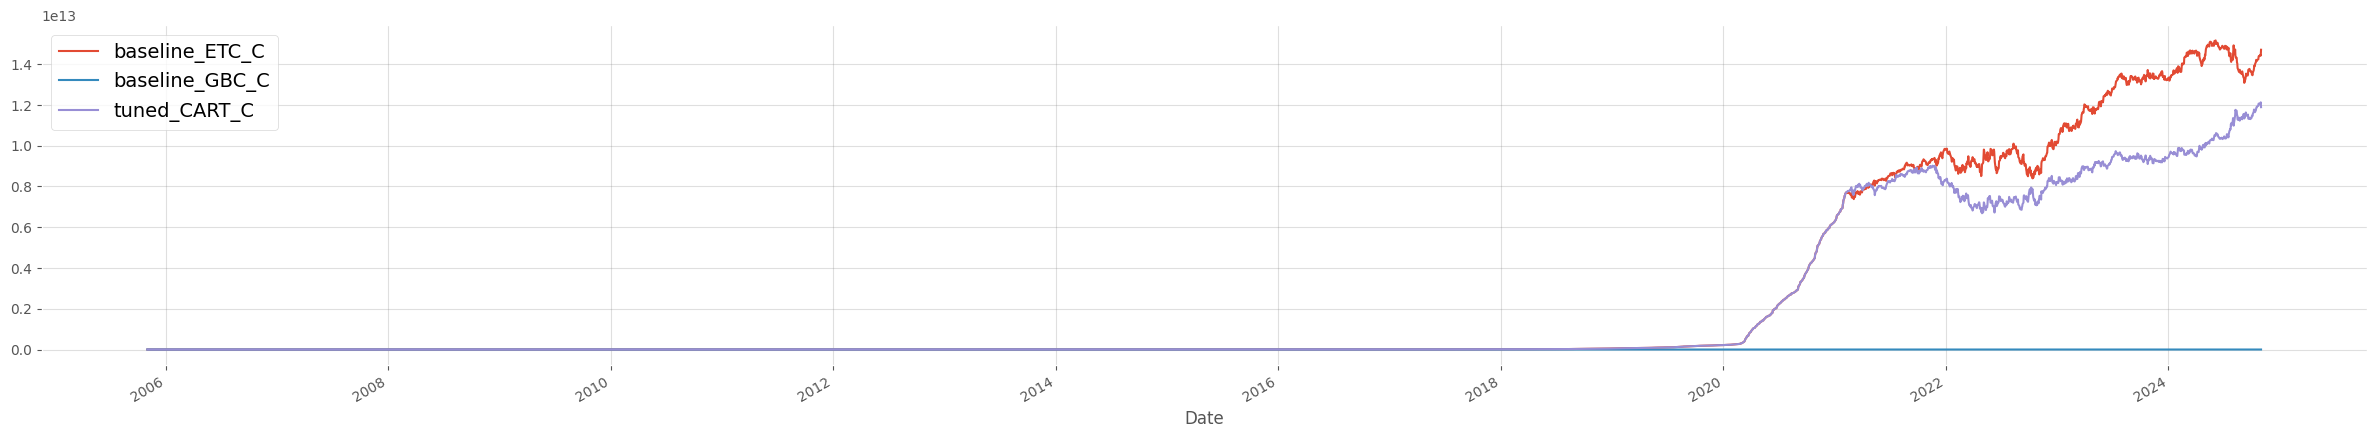

In [63]:
top3 = all_strategies_metrics["strategy"].to_list()[:3]

all_strategies = pd.DataFrame.from_dict(strategies_returns, orient="index")
all_strategies = all_strategies[all_strategies.index.isin(top3)].T
all_strategies = np.exp(all_strategies.cumsum())
all_strategies.index = SPY_price.index

all_strategies.plot()

In [64]:
all_strategies_metrics[all_strategies_metrics["strategy"].isin(top3)]

,strategy,sharpe,max_dd %,annualized_returns %,final_amount,VaR,CAGR
5,baseline_ETC_C,1.402652,-16.848546,23.283789,220466.132047,-28013.535413,0.231454
8,baseline_GBC_C,1.154099,-19.061176,19.175825,195233.765400,-32169.637396,0.192661
12,tuned_CART_C,0.996511,-25.874212,16.566095,178249.462860,-34806.218472,0.164415


## <a id = "summary"></a><font color = blue> 👉 Part 3.1: Executive Summary</font> [back to table of contents](#top)

# Whole Period Metrics
|  | Baseline ExtraTreesClassifier | Tuned DecisionTreeClassifier| Baseline ExtraTreesRegressor |
| --- | --- | --- | --- |
| **Performance Metrics** ||| 
| Ending Value | 1,470,138,566,248,620,000 | 1,188,624,335,769,850,000 | 1,095,884,852,357,860,000 |
| Annualized Returns |394.18%|388.68% | 386.59% |
| Sharpe Ratio |23.86|23.47|23.32|
| CAGR |392.74% |387.26% |385.18%|
|  |  |  |  |
| **Risk Metrics** |  |  |  |
| Max Drawdown |-16.85%|-25.87%|-21.8%|
| Parametric VaR (99.9% 1-Year) | 343,135 | 337,498 | 335,360|

# Out-of-Sample Metrics
|  | Baseline ExtraTreesClassifier | Tuned DecisionTreeClassifier| Baseline ExtraTreesRegressor |
| --- | --- | --- | --- |
| **Performance Metrics** |||
| Ending Value | 220,466.13|178,249.46|164,342.00|
| Annualized Returns |23.28%|16.57% | 14.09% |
| Sharpe Ratio |1.4|1.0|0.85|
| CAGR |23.14% |16.44% |13.97%|
|  |  |  |  |
| **Risk Metrics** |  |  |  |
| Max Drawdown |-16.85%|-25.87%|-21.8%|
| Parametric VaR (99.9% 1-Year) |-28,013.53| -34,806.22|-37,298.26|


## Explanation for Choice of Models

**Baseline ExtraTreesClassifier**
>The Baseline ExtraTreesClassifier performed the best in the out-of-sample test set. The model produced a respectable Sharpe of 1.4, and lower max drawdown versus the SPY ETF itself (-33.7% from past 5 years). The model also outperformed the ETF in terms of annualized returns (23.28% vs 10.59% SPY).
The 99.9% 1-Year VaR is also acceptable at -28,013.

**Tuned DecisionTreeClassifier**
>The Tuned DecisionTreeClassifier performed the best in the out-of-sample test set. The model produced a Sharpe of 1.0, and lower max drawdown versus the SPY ETF itself (-33.7% from past 5 years). The model also outperformed the ETF in terms of annualized returns (16.57% vs 10.59% SPY).
The 99.9% 1-Year VaR is also acceptable at -34,806.
>The hyperparameter tuning also allowed it outperform the default DecisionTreeClassifier.

##### __**We outline the differences between the tree classifiers below.**__
||  Decision Tree | Extra Trees |
| --- | --- | --- 
|# of Trees|1|Many|
|# of features considered for split at each decision node|All features|Random subset of features|
|How split is made|Best split|Random|

**Baseline ExtraTreesRegressor**
>The Baseline ExtraTreesRegressor performed the best in the out-of-sample test set. The model produced a Sharpe of 0.85, and lower max drawdown versus the SPY ETF itself (-33.7% from past 5 years). The model also outperformed the ETF in terms of annualized returns (14.09% vs 10.59% SPY).

## <a id = "part4"></a><font color = blue> 👉 Part 4: Critique </font> [back to table of contents](#top)

# Why Some Strategies Work

**Trend Following**
##### Momentum Crashes 
>Momentum occurs when a previously trending asset or market experiences a sudden, sharp reversal. This often happens when trend-following investors have increase short positions on low momentum stocks (“losers”), such that prices have so deflated that have a high risk/return premium as compared the high momentum stocks (“winners”). During the market reversal, the losers are able to “crash upwards” and recover a significant amount in a short time horizon. This is evident during the initial crash of the COVID-19 pandemic. Had our model been on the short side due to the trend-following strategy, we would have a huge drawdown and potentially not be able to recover. 

**Mean Reversion** 
##### The Reversion Never Happens 
>For long-term uptrend assets like SPY, mean reversion may never occur in the way expected. While many anticipate corrections or pullbacks when prices become "too high", markets tend to trend upwards over the long term. Trying to time these reversals can be problematic; we might either wait for a correction that never materializes, or worse, short the ETF and suffer losses as it continues to climb. As a result, relying on mean reversion in a strong uptrend can lead to missed opportunities or significant losses. 

**Machine Learning**
##### Overfitting  
>Given that the historical data spans 20 years and the evaluation period is also 20 years, the training set would inevitably be included in the evaluation period. This results in overfitting as models trained on the first 80% of the data would have already 'seen' the data and hence would outperform during the evaluation period. Such an approach is flawed and will result in biased, unrealistic results. The models' ability to generalize and generate signals would be artificially inflated. The evaluation results do not reflect the true out of sample predictive power of the model. 

# Critique of Trading Strategies
**Position Sizing** 

> This assignment assumes that we are fully investing our portfolio when a signal is generated. In practice, this approach may not be feasible or ideal, as it is prudent to maintain a cash allocation for liquidity needs, unforeseen expenses, or risk management. 

**Transaction Costs**

> Backtesting is often conducted in an ideal, but unrealistic world without transaction costs, constraints, or limits on the availability of long and short positions. In reality, managers may face numerous constraints, such as limits on turnover and difficulties in establishing short positions in certain markets. Depending on how fast the trading signal decays, we may not be able to capture the model’s expected return in a live trading process, or may have eroded returns due to transaction cost drag. 

> An example of transaction costs is slippage. Slippage is measured as the difference between the execution price and the mid-price at trade inception. It incorporates both the effect of volatility costs, and market impact. Volatility costs are the costs associated with buying in a rising market and selling in a declining market. This measure provides an estimate of the cost to execute a transaction when the order is executed in a single trade. 

> This would reduce the performance of the strategies if included. Without accounting for transaction fees, we can trade as frequently as the model signals, leading to potentially unrealistic results. 

> We are also assuming the ability to buy and sell at the daily closing prices. In reality, this does not capture the impact of slippage, where orders may not execute exactly at the close price due to market volatility or liquidity constraints. 

**Short Positions and Margin Requirements**

> Shorting an equity is constrained by the short seller’s need to locate shares to short, the requirement to reimburse dividends on borrowed shares, and requirements to post and pay interest on margin that generally exceeds the margin required for long equity positions. 

> Our model does not account for the need to maintain margin or collateral. In real-world trading, when taking short positions, a portion of the portfolio must be reserved to cover potential margin calls or fluctuations in the shorted asset’s price. 

**Survivorship Bias**

> Survivorship bias is one of the most common issues affecting quantitative decision making. When backtests use only those companies that are currently in still in operation today, they ignore the stocks that have left the investment universe due to bankruptcy, delisting, or acquisition. This approach creates a bias whereby only companies that have survived are tested and it is assumed that the strategy would never have invested in companies that have failed. Survivorship bias often leads to overly optimistic results and sometimes even causes investors to draw wrong conclusions. 

**Look-Ahead Bias**

> The next issue to look out for in backtesting is look-ahead bias. This bias results from using information that was unknown or unavailable at the time an investment decision was made. An example of this is not using the shift method on the signal generation step, which will incorrect allow the model trade with look-ahead bias. 

**Data Mining and Overfitting**

> Data mining refers to automated computational processes for discovering patterns in large datasets, often utilizing statistical techniques, computation algorithms, and massive database systems. In training our strategy, we may introduce a bias that results in model overfitting. It can be described as excessive search analysis of past financial data to uncover patterns and to conform to a pre-determined model for potential use in investing.  

**Market Regime Shift** 

> Changes in technological, political, legal, and regulatory environments; disruptions such as wars and other calamities; and changes in policy stances can all alter risk–return relationships, which gives rise to the problem of non-stationarity. 

> A simple way to determine appropriate samples for time-series estimation is to look at graphs of the data to see if the time series looks stationary before estimation begins. For example, we might test whether the time-series relation was the same before and after a change in political regime of the USA. 

**Style & Sector Concentration Risks**

> The S&P 500 index is, by definition, a large-cap index weighted by market capitalization. 

> This means that if our model is only allowed to trade on the SPY ETF, we are inherently restricting our strategy to only hold an investment vehicle that has an over-exposure to large-cap stocks (negative SMB factor) and an over-exposure to the technology sector (FAANG). 

> This give the illusion of diversification by 500 stocks, but in actuality the risk factors are overly concentrated. 

**Crowding Effect** 

> The crowding effect occurs when too many investors or traders adopt the same strategy or asset simultaneously, which can lead to diminished returns, increased volatility, and liquidity issues. As prof has went through the various strategies in class, majority of our classmates would employ the same strategy when doing this assignment. In the real world, when too many participants follow the same signals, the market may becomes efficient, and strategies that once worked can break down as the underlying assumptions are no longer valid. 

# Importance of Internal Discussions

**Encourage Diverse Perspectives**
>Our team encompasses members from both regulatory and asset management backgrounds, from software engineers, risk managers and index analytics. We are confident that by fostering an open, safe discussion space, the group's capabilities will far overcome the sum of our each individual.

**Promote Continuous Learning**
>Critique sessions provide a platform to exchange insights, learn from mistakes, and incorporate each other's strength. This culture of learning ensures that each team member evolves alongside each other.

**Mitigate Risk**
>By identifying and addressing potential biases and errors in strategy design, these discussions play a crucial role in risk mitigation.
>We acknowledge that the S&P500 is not risk-factor diversified, and that this strategy has a high concentration risk in the Technology sector, as well as a big SMB factor tilt.
>But we will follow our mandate.

**Drive Innovation**
>While striving for continuous learning, we acknowledge the positive impact of learning other fields of study, such as biology and political science. This will enable us to incorporate extremely different practices together to drive innovation.

**Overall Impact**
>The diverse professional backgrounds of the team, along with the encouraging atmosphere, enabled our team to complete the assignment to the best of our abilities.

## <a id = "Best"></a><font color = blue> 👉 Best </font> [back to table of contents](#top)

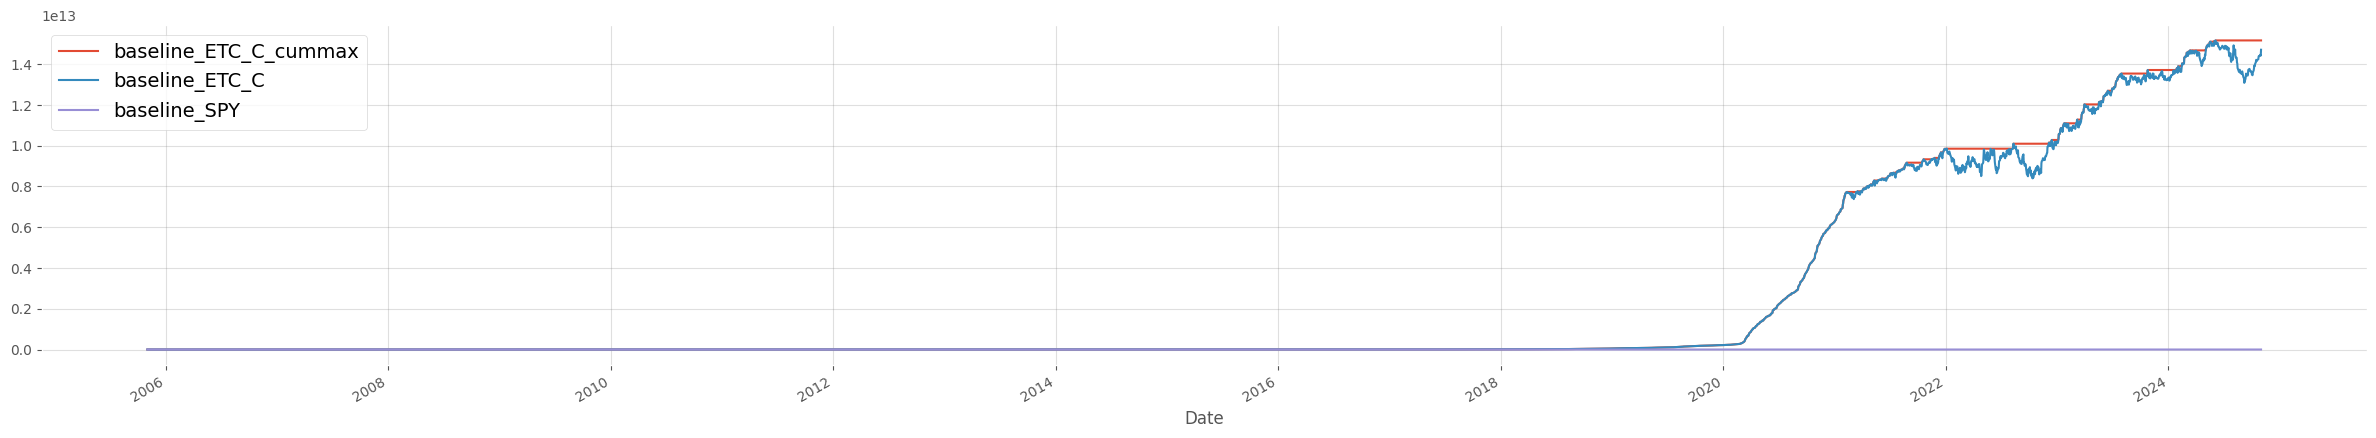

In [53]:
best = all_strategies_metrics["strategy"].iloc[0]

best_strategy = all_strategies[[best]]
best_strategy[f"{best}_cummax"] = best_strategy[best].cummax()
best_strategy["baseline_SPY"] = np.exp(strategies_returns["baseline"].cumsum())
best_strategy["position"] = strategies_positions[best]
best_strategy["SPY_price"] = SPY_price

best_strategy[[f"{best}_cummax", best, "baseline_SPY"]].plot();

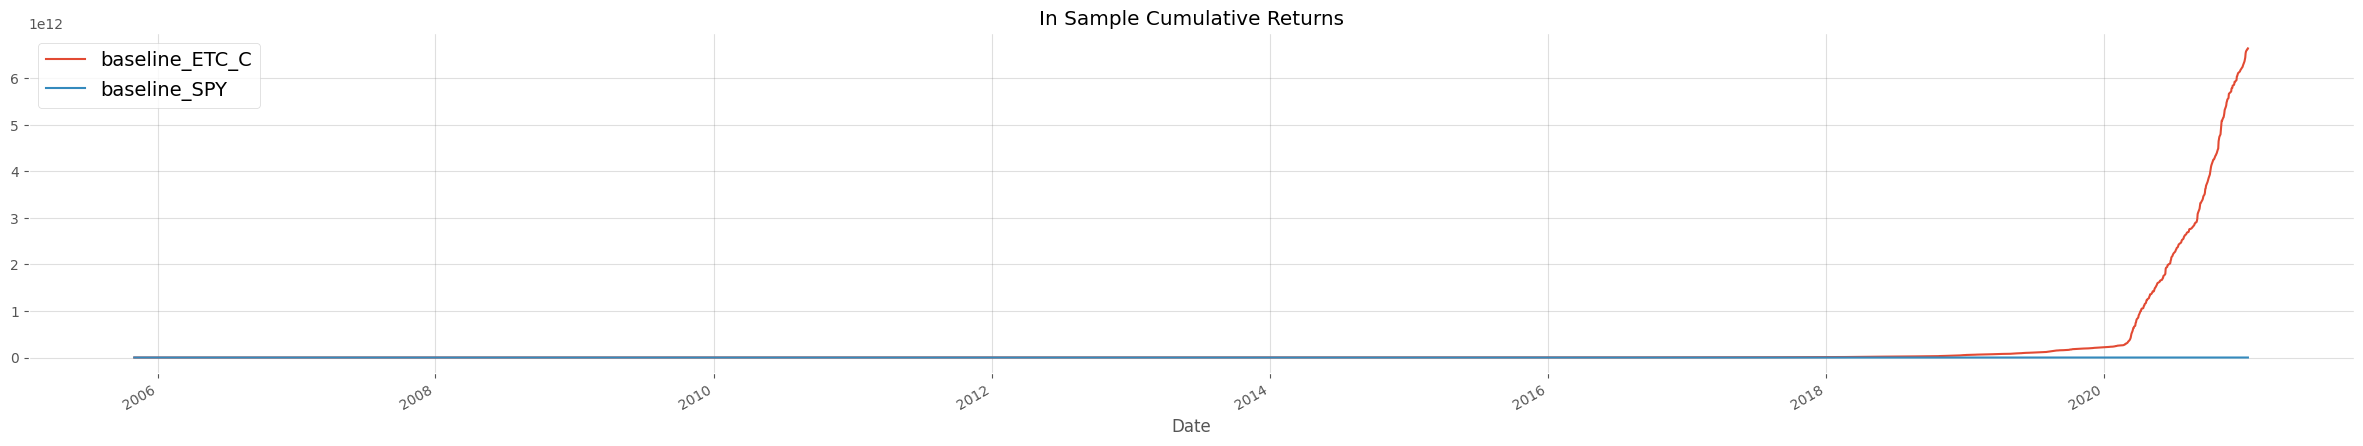

In [54]:
in_sample = best_strategy[best_strategy.index.isin(ideation_index)]
in_sample[best] = in_sample[best] / in_sample[best].iloc[0]
in_sample["baseline_SPY"] = (
    in_sample["baseline_SPY"] / in_sample["baseline_SPY"].iloc[0]
)

in_sample[[best, "baseline_SPY"]].plot()
plt.title("In Sample Cumulative Returns");

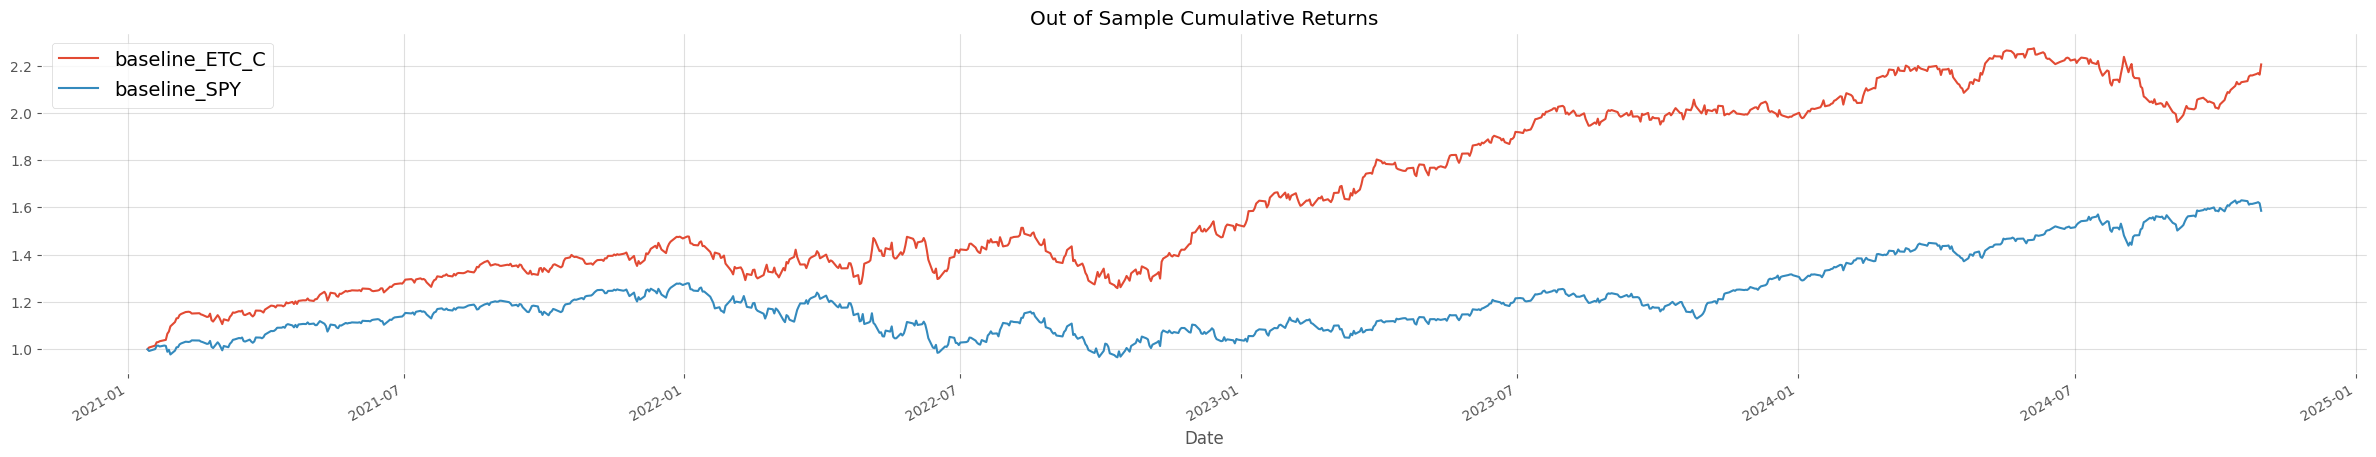

In [55]:
oos = best_strategy[best_strategy.index.isin(testing_index)]
oos[best] = oos[best] / oos[best].iloc[0]
oos["baseline_SPY"] = oos["baseline_SPY"] / oos["baseline_SPY"].iloc[0]

oos[[best, "baseline_SPY"]].plot()

plt.title("Out of Sample Cumulative Returns");

In [ ]:
for period, index in periods.items():
    metrics = {
        "strategy": [],
        "sharpe": [],
        "max_dd %": [],
        "annualized_returns %": [],
        "final_amount": [],
        "CAGR": [],
        "VaR": [],
    }

    metrics = append_metrics(
        strategies=["baseline", best],
        returns=strategies_returns,
        metrics=metrics,
        filter_period=index,
    )

    print(period)
    all_strategies_metrics = pd.DataFrame.from_dict(metrics).sort_values(
        by="final_amount", ascending=False
    )
    display(all_strategies_metrics)

In Sample


,strategy,sharpe,max_dd %,annualized_returns %,final_amount,CAGR,VaR
1,baseline_ETC_C,38.018962,0.000000,599.125583,664496588568411392.000000,5.965901,550427.850780
0,baseline,0.502843,-55.189451,10.058351,428492.180908,0.100386,-51755.502145


Out of Sample


,strategy,sharpe,max_dd %,annualized_returns %,final_amount,CAGR,VaR
1,baseline_ETC_C,1.402652,-16.848546,23.283789,220466.132047,0.231454,-28013.535413
0,baseline,0.770372,-24.496399,12.814965,158556.722682,0.129063,-38590.377231


Whole Period


,strategy,sharpe,max_dd %,annualized_returns %,final_amount,CAGR,VaR
1,baseline_ETC_C,23.861915,-16.848546,394.183670,1470138566248628992.000000,3.927418,343134.996538
0,baseline,0.547258,-55.189451,10.604003,677023.789962,0.105836,-49274.202282


In [57]:
%whos

Variable                          Type                   Data/Info
------------------------------------------------------------------
ARIMA                             type                   <class 'statsmodels.tsa.arima.model.ARIMA'>
AdaBoostClassifier                ABCMeta                <class 'sklearn.ensemble.<...>ting.AdaBoostClassifier'>
AdaBoostRegressor                 ABCMeta                <class 'sklearn.ensemble.<...>sting.AdaBoostRegressor'>
DecisionTreeClassifier            ABCMeta                <class 'sklearn.tree._cla<...>.DecisionTreeClassifier'>
DecisionTreeRegressor             ABCMeta                <class 'sklearn.tree._cla<...>s.DecisionTreeRegressor'>
ElasticNet                        ABCMeta                <class 'sklearn.linear_mo<...>nate_descent.ElasticNet'>
ExtraTreesClassifier              ABCMeta                <class 'sklearn.ensemble.<...>st.ExtraTreesClassifier'>
ExtraTreesRegressor               ABCMeta                <class 'sklearn.ensemble.<...>

### <font color = green> 💯 Thank you for Prof for the semester 😊

## Contributions
>Everyone contributed to this group project

>We all added code to this jupyter notebook, with special acknowledgement to Edmund Chia for writing the majority of it.
>Edmund contributed to the classes used, as well as overall workflow.

>We all provided feedback and ideas, with special mention to Ashley Tan for bringing a sizable portion of new data insights & model architecture.
Ashley was responsible of identifying impactful exogenous features from various asset classes to enhance overall model performance as well as construct and analysis of all regression models.

>We all contributed to the report, with special recognition to Lee Zong Kang (Jacob) for a substantial amount of words typed.
>Jacob contributed to the overal streamlining of the code, as well as providing qualitative insights to the returns & risk profile of the strategy.